# Project Notes

## Outline

This project was designed to evaluate a Differential Gene Expression Analysis workflow following the same approach published in [Empirical assessment of analysis workflows for differential expression analysis of human samples using RNA-Seq]( https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1457-z) by Williams _at al_.

We tested five workflows for the DGA. All workflows used the same aligner (STAR) and quantification (TPMCalculator) tool but different DGA software: EdgeR, Deseq2, SAMSeq, the union and the intercept off all identified genes from all DGA tools. Recall and precision values were calculated using the same approach described in the paper using the expressions: 

$Recall = \frac{G_{r} \cup G_{d}}{G_{d}}$

$Precision = \frac{G_{r} \cup G_{d}}{G_{r}}$

$G_r$ genes in reference and $G_d$ genes identified

We used paper's figure 5a to plot our results for comparison with the paper published results. Although, we obtained recall values under the fitted line our precision is over the fitting line showing better results  than those published in the paper, see final plots [here](#8.-Correlation-with-published-results). 

This analysis is testing the whole workflow STAR-TPMCalculator-DGA tool. In our case, we use the same tools than in the paper for alignment (STAR) and DGA (EdgeR, Deseq2 and SAMSeq). The only difference is the quantification step using TPMCalculator. Additionally, we used their scripts and parameters for the DGA tools which all are R packages. 

We see an increment of the precision despite of using the same first and last steps published in the paper for the STAR-quantification-DGA based workflows. We concluded that the increment in precision is due to the introduction of the TPMCalculator tool.

Our workflow is based on a set of Jupyter Notebooks and [CWL workflows](https://gitlab.com/r78v10a07/cwl-workflow/). The workflows excuted the analysis using the following tools: 

 * FastQC, for pre-processing quality control
 * Trimmomatic, for reads trimming
 * STAR, for reads alignment
 * RSeQC, for alignment quality control
 * TPMCalculator, for mRNA abundance quantification
 * Deseq2, for DGA
 * EdgeR, for DGA
 * SAMseq, for DGA

### Workflow  steps

 1. [Sample retrieval from SRA database](#1.-Sample-retrieval-from-SRA-database)
 2. [Pre-processing QC](#2.-Pre-processing-QC)
 3. [Trimming](#3.-Trimming)
 4. [Alignment](#4.-Alignment)
 5. [Alignment Quality Control](#5.-Alignment-QC)
 6. [Quantification](#6.-Quantification)
 7. [Differential Gene Expression Analysis](#7.-Differential-Gene-Expression-Analysis)
 8. [Correlation with published results](#8.-Correlation-with-published-results)
 
### Requirements

 1. Python 3.6
    - numpy
    - scipy
    - pandas
    - seaborn
    - matplotlib
    - jupyter
    - cwltool
 2. CWL Tools definition files: [cwl-workflow](https://gitlab.com/r78v10a07/cwl-workflow/)       

In [1]:
%run ../config/init.py
import gzip
import base64
from io import StringIO
from wand.image import Image as WImage
HTML(HIDE_CODE)

## 1. Sample retrieval from SRA database

### BioProject ID: PRJNA339968

In [2]:
os.chdir(os.environ['NOTEBOOKS'])
name = '01 - Sample Retrieval'
str_msg = '<a href="' + name.replace(' ', '%20') + '.html" target="_blank">' + name + '</a>\n'
display(Markdown(str_msg))

f = os.path.join(os.environ['DATA'], os.environ['DATASET'], 'samples.tsv')
df = pandas.read_csv(f, sep='\t')
display(df)
del str_msg

<a href="01%20-%20Sample%20Retrieval.html" target="_blank">01 - Sample Retrieval</a>


ALIAS   ACCESSION         RUN
0   nonclassical11  SRS1658418  SRR4098783
1      classical17  SRS1658417  SRR4098782
2      classical11  SRS1658416  SRR4098781
3      classical12  SRS1636112  SRR4053825
4      classical10  SRS1636111  SRR4053824
5      classical09  SRS1636110  SRR4053823
6      classical08  SRS1636108  SRR4053822
7      classical07  SRS1636109  SRR4053821
8      classical05  SRS1636107  SRR4053820
9   nonclassical18  SRS1636106  SRR4053819
10     classical04  SRS1636105  SRR4053818
11  nonclassical17  SRS1636104  SRR4053817
12  nonclassical16  SRS1636103  SRR4053816
13  nonclassical14  SRS1636102  SRR4053815
14  nonclassical13  SRS1636101  SRR4053814
15  nonclassical12  SRS1636100  SRR4053813
16  nonclassical10  SRS1636099  SRR4053812
17  nonclassical09  SRS1636098  SRR4053811
18  nonclassical08  SRS1636097  SRR4053810
19  nonclassical07  SRS1636096  SRR4053809
20  nonclassical06  SRS1636095  SRR4053808
21     classical03  SRS1636094  SRR4053807
22  nonclassical05  SRS1636093  SRR4053806
23  nonclassical04  SRS1636092  SRR4053805
24  nonclassical03  SRS1636091  SRR4053804
25  nonclassical02  SRS1636090  SRR4053803
26  nonclassical01  SRS1636089  SRR4053802
27     classical18  SRS1636088  SRR4053801
28     classical16  SRS1636087  SRR4053800
29     classical15  SRS1636086  SRR4053799
30     classical14  SRS1636085  SRR4053798
31     classical13  SRS1636084  SRR4053797
32     classical02  SRS1636083  SRR4053796
33     classical01  SRS1636082  SRR4053795

In [3]:
data_dir = os.path.join(os.environ['DATA'], os.environ['DATASET'])
os.chdir(data_dir)
samples = [ f.replace('.fastq.gz','') for ds,dr,fs in os.walk('./') for f in fs if f.endswith('.fastq.gz')]
samples.sort()

## 2. Pre-processing QC

In [4]:
os.chdir(os.environ['NOTEBOOKS'])
samples_data = {}
name = '02 - Pre-processing Quality Control'
str_msg = '<a href="' + name.replace(' ', '%20') + '.html" target="_blank">' + name + '</a>\n'
str_msg += '#### FastQC report\n'
str_msg += '| Sample | Fastq | FastQC<br>Report | No of Reads<br>in fastq | Seq<br> Len | %GC | Poor<br>Quality | Fail<br>Tests |\n'
str_msg += '| --- | --- | --- |--- | --- | --- | --- | --- |\n'
for s in samples:
    str_msg += '| ' + s
    str_msg += '| '
    f = os.path.relpath(os.path.join(os.environ['DATA'], os.environ['DATASET'], s + '.fastq.gz'))
    if os.path.exists(f):
        size = os.path.getsize(f)/(1024.0*1024.0)
        str_msg += ' <a href="' 
        str_msg += f.replace(' ', '%20') 
        str_msg += '" target="_blank">'
        str_msg += "{0:.2f}".format(size)
        str_msg += 'MB</a> |'
    else:
        str_msg += ' --- |'
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'fastqc', s + '_fastqc.html'))
    if os.path.exists(f):
        size = os.path.getsize(f)/(1024.0)
        str_msg += ' <a href="' 
        str_msg += f.replace(' ', '%20') 
        str_msg += '" target="_blank">'
        str_msg += "{0:.2f}".format(size)
        str_msg += 'KB</a> |'
    else:
        str_msg += ' --- |'
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'fastqc', s + '_fastqc.zip'))
    if os.path.exists(f):
        tests, tot_seq, poor_quality, seq_len, gc_content = parse_fastqc_zip(s, f)
        samples_data[s] = {'fastqc' : 
                           {
                               'tests':tests,
                               'tot_seq': tot_seq,
                               'poor_quality': poor_quality,
                               'seq_len': seq_len,
                               'gc_content': gc_content
                           }
                          }
        str_msg += "{:,}".format(tot_seq) + '|'
        str_msg += seq_len + '|'
        str_msg += gc_content + '|'
        str_msg += str(poor_quality) + '|'
        fail_tests = ''
        for t in tests:
            if tests[t] == 'FAIL':
                if fail_tests:
                    fail_tests += '<br>'
                fail_tests += t
        str_msg += fail_tests + '|\n'
                    
    else:
        str_msg += ' --- | --- | --- | --- | --- |\n'
display(Markdown(str_msg))
del str_msg

<a href="02%20-%20Pre-processing%20Quality%20Control.html" target="_blank">02 - Pre-processing Quality Control</a>
#### FastQC report
| Sample | Fastq | FastQC<br>Report | No of Reads<br>in fastq | Seq<br> Len | %GC | Poor<br>Quality | Fail<br>Tests |
| --- | --- | --- |--- | --- | --- | --- | --- |
| SRR4053795|  <a href="../data/PRJNA339968/SRR4053795.fastq.gz" target="_blank">763.23MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053795_fastqc.html" target="_blank">258.95KB</a> |13,198,444|51|41|0|Per base sequence content|
| SRR4053796|  <a href="../data/PRJNA339968/SRR4053796.fastq.gz" target="_blank">1861.90MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053796_fastqc.html" target="_blank">255.90KB</a> |33,389,661|51|43|0|Per base sequence content<br>Sequence Duplication Levels|
| SRR4053797|  <a href="../data/PRJNA339968/SRR4053797.fastq.gz" target="_blank">1524.77MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053797_fastqc.html" target="_blank">257.13KB</a> |28,895,172|51|43|0|Per base sequence content<br>Sequence Duplication Levels|
| SRR4053798|  <a href="../data/PRJNA339968/SRR4053798.fastq.gz" target="_blank">1281.82MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053798_fastqc.html" target="_blank">258.63KB</a> |24,061,679|51|44|0|Per base sequence content<br>Sequence Duplication Levels|
| SRR4053799|  <a href="../data/PRJNA339968/SRR4053799.fastq.gz" target="_blank">743.46MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053799_fastqc.html" target="_blank">256.88KB</a> |13,712,693|51|44|0|Per base sequence content|
| SRR4053800|  <a href="../data/PRJNA339968/SRR4053800.fastq.gz" target="_blank">1004.78MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053800_fastqc.html" target="_blank">257.23KB</a> |18,133,328|51|44|0|Per base sequence content|
| SRR4053801|  <a href="../data/PRJNA339968/SRR4053801.fastq.gz" target="_blank">226.20MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053801_fastqc.html" target="_blank">255.36KB</a> |4,242,373|51|43|0|Per base sequence content|
| SRR4053802|  <a href="../data/PRJNA339968/SRR4053802.fastq.gz" target="_blank">514.00MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053802_fastqc.html" target="_blank">258.96KB</a> |8,870,301|51|43|0|Per base sequence content|
| SRR4053803|  <a href="../data/PRJNA339968/SRR4053803.fastq.gz" target="_blank">1455.97MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053803_fastqc.html" target="_blank">264.65KB</a> |27,432,709|51|50|0|Per base sequence content<br>Per sequence GC content<br>Sequence Duplication Levels|
| SRR4053804|  <a href="../data/PRJNA339968/SRR4053804.fastq.gz" target="_blank">1796.18MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053804_fastqc.html" target="_blank">255.33KB</a> |32,385,102|51|45|0|Per base sequence content|
| SRR4053805|  <a href="../data/PRJNA339968/SRR4053805.fastq.gz" target="_blank">1636.32MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053805_fastqc.html" target="_blank">257.14KB</a> |29,819,425|51|43|0|Per base sequence content|
| SRR4053806|  <a href="../data/PRJNA339968/SRR4053806.fastq.gz" target="_blank">1368.05MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053806_fastqc.html" target="_blank">257.76KB</a> |24,659,564|51|46|0|Per base sequence content|
| SRR4053807|  <a href="../data/PRJNA339968/SRR4053807.fastq.gz" target="_blank">2068.23MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053807_fastqc.html" target="_blank">257.80KB</a> |37,278,863|51|42|0|Per base sequence content|
| SRR4053808|  <a href="../data/PRJNA339968/SRR4053808.fastq.gz" target="_blank">1026.55MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053808_fastqc.html" target="_blank">255.83KB</a> |18,194,803|51|45|0|Per base sequence content|
| SRR4053809|  <a href="../data/PRJNA339968/SRR4053809.fastq.gz" target="_blank">909.93MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053809_fastqc.html" target="_blank">260.20KB</a> |16,097,538|51|48|0|Per base sequence content<br>Per sequence GC content<br>Sequence Duplication Levels|
| SRR4053810|  <a href="../data/PRJNA339968/SRR4053810.fastq.gz" target="_blank">1226.11MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053810_fastqc.html" target="_blank">255.66KB</a> |21,566,882|51|45|0|Per base sequence content|
| SRR4053811|  <a href="../data/PRJNA339968/SRR4053811.fastq.gz" target="_blank">252.76MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053811_fastqc.html" target="_blank">254.55KB</a> |4,534,711|51|45|0|Per base sequence content|
| SRR4053812|  <a href="../data/PRJNA339968/SRR4053812.fastq.gz" target="_blank">402.95MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053812_fastqc.html" target="_blank">254.15KB</a> |6,991,927|51|45|0|Per base sequence content|
| SRR4053813|  <a href="../data/PRJNA339968/SRR4053813.fastq.gz" target="_blank">1675.39MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053813_fastqc.html" target="_blank">260.49KB</a> |30,968,831|51|50|0|Per base sequence content<br>Per sequence GC content<br>Sequence Duplication Levels|
| SRR4053814|  <a href="../data/PRJNA339968/SRR4053814.fastq.gz" target="_blank">1083.07MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053814_fastqc.html" target="_blank">256.33KB</a> |19,672,615|51|43|0|Per base sequence content|
| SRR4053815|  <a href="../data/PRJNA339968/SRR4053815.fastq.gz" target="_blank">1877.80MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053815_fastqc.html" target="_blank">257.28KB</a> |33,724,967|51|47|0|Per base sequence content<br>Per sequence GC content<br>Sequence Duplication Levels|
| SRR4053816|  <a href="../data/PRJNA339968/SRR4053816.fastq.gz" target="_blank">1355.75MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053816_fastqc.html" target="_blank">254.09KB</a> |23,811,719|51|45|0|Per base sequence content|
| SRR4053817|  <a href="../data/PRJNA339968/SRR4053817.fastq.gz" target="_blank">1022.22MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053817_fastqc.html" target="_blank">253.32KB</a> |17,979,676|51|45|0|Per base sequence content|
| SRR4053818|  <a href="../data/PRJNA339968/SRR4053818.fastq.gz" target="_blank">952.41MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053818_fastqc.html" target="_blank">257.16KB</a> |17,341,127|51|42|0|Per base sequence content|
| SRR4053819|  <a href="../data/PRJNA339968/SRR4053819.fastq.gz" target="_blank">1404.15MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053819_fastqc.html" target="_blank">255.64KB</a> |25,248,515|51|45|0|Per base sequence content|
| SRR4053820|  <a href="../data/PRJNA339968/SRR4053820.fastq.gz" target="_blank">1586.10MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053820_fastqc.html" target="_blank">258.36KB</a> |28,708,344|51|44|0|Per base sequence content<br>Per sequence GC content<br>Sequence Duplication Levels|
| SRR4053821|  <a href="../data/PRJNA339968/SRR4053821.fastq.gz" target="_blank">1387.75MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053821_fastqc.html" target="_blank">257.41KB</a> |24,371,494|51|43|0|Per base sequence content<br>Sequence Duplication Levels|
| SRR4053822|  <a href="../data/PRJNA339968/SRR4053822.fastq.gz" target="_blank">1175.24MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053822_fastqc.html" target="_blank">254.97KB</a> |20,591,873|51|43|0|Per base sequence content|
| SRR4053823|  <a href="../data/PRJNA339968/SRR4053823.fastq.gz" target="_blank">521.62MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053823_fastqc.html" target="_blank">255.50KB</a> |9,355,083|51|43|0|Per base sequence content|
| SRR4053824|  <a href="../data/PRJNA339968/SRR4053824.fastq.gz" target="_blank">619.72MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053824_fastqc.html" target="_blank">256.50KB</a> |10,934,200|51|42|0|Per base sequence content|
| SRR4053825|  <a href="../data/PRJNA339968/SRR4053825.fastq.gz" target="_blank">1324.58MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4053825_fastqc.html" target="_blank">255.75KB</a> |24,908,286|51|43|0|Per base sequence content<br>Sequence Duplication Levels|
| SRR4098781|  <a href="../data/PRJNA339968/SRR4098781.fastq.gz" target="_blank">1317.19MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4098781_fastqc.html" target="_blank">258.20KB</a> |24,522,481|51|44|0|Per base sequence content|
| SRR4098782|  <a href="../data/PRJNA339968/SRR4098782.fastq.gz" target="_blank">1306.09MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4098782_fastqc.html" target="_blank">255.28KB</a> |23,836,594|51|44|0|Per base sequence content<br>Sequence Duplication Levels|
| SRR4098783|  <a href="../data/PRJNA339968/SRR4098783.fastq.gz" target="_blank">1599.43MB</a> | <a href="../results/PRJNA339968/fastqc/SRR4098783_fastqc.html" target="_blank">257.93KB</a> |28,601,429|51|46|0|Per base sequence content<br>Per sequence GC content|


## 3. Trimming

### Trimmomatic options

 * IlluminaClip: TruSeq3-SE.fa:2:30:10
 * Crop: 75
 * Headcrop: 10
 * Minlen: 30
 * Avgqual: 30
 * Leading: 30
 * Trailing: 30

In [5]:
os.chdir(os.environ['NOTEBOOKS'])
name = '03 - Samples trimming'
str_msg = '<a href="' + name.replace(' ', '%20') + '.html" target="_blank">' + name + '</a>\n\n'
str_msg += '| Sample | Trimmed<br>Fastq | FastQC<br>Report | No of Reads<br>in fastq | Removed<br>Reads | Seq<br> Len | %GC | Poor<br>Quality | Fail<br>Tests |\n'
str_msg += '| --- | --- | --- | --- | --- | --- | --- | --- | --- |\n'
for s in samples:
    str_msg += '| ' + s
    str_msg += '| '
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'trimmomatic', s + '_tr.fastq.gz'))
    if os.path.exists(f):
        size = os.path.getsize(f)/(1024.0*1024.0)
        str_msg += ' <a href="' 
        str_msg += f.replace(' ', '%20') 
        str_msg += '" target="_blank">'
        str_msg += "{0:.2f}".format(size)
        str_msg += 'MB</a> |'
    else:
        str_msg += ' --- |'
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'trimmomatic', 'fastqc', s + '_tr_fastqc.html'))
    if os.path.exists(f):
        size = os.path.getsize(f)/(1024.0)
        str_msg += ' <a href="' 
        str_msg += f.replace(' ', '%20') 
        str_msg += '" target="_blank">'
        str_msg += "{0:.2f}".format(size)
        str_msg += 'KB</a> |'
    else:
        str_msg += ' --- |'
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'trimmomatic', 'fastqc', s + '_tr_fastqc.zip'))
    if os.path.exists(f):
        tests, tot_seq, poor_quality, seq_len, gc_content = parse_fastqc_zip(s + '_tr', f)
        str_msg += "{:,}".format(tot_seq) + '|'
        str_msg += "{:,}".format(samples_data[s]['fastqc']['tot_seq'] - tot_seq) + '|'
        str_msg += seq_len + '|'
        str_msg += gc_content + '|'
        str_msg += str(poor_quality) + '|'
        fail_tests = ''
        for t in tests:
            if tests[t] == 'FAIL':
                if fail_tests:
                    fail_tests += '<br>'
                fail_tests += t
        str_msg += fail_tests + '|\n'
        samples_data[s]['trimmed'] = {
            'tests':tests,
            'tot_seq': tot_seq, 
            'poor_quality': poor_quality, 
            'seq_len': seq_len,
            'gc_content': gc_content
        }
    else:
        str_msg += ' --- | --- | --- | --- | --- | --- |\n'
display(Markdown(str_msg))
del str_msg

<a href="03%20-%20Samples%20trimming.html" target="_blank">03 - Samples trimming</a>

| Sample | Trimmed<br>Fastq | FastQC<br>Report | No of Reads<br>in fastq | Removed<br>Reads | Seq<br> Len | %GC | Poor<br>Quality | Fail<br>Tests |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| SRR4053795|  <a href="../results/PRJNA339968/trimmomatic/SRR4053795_tr.fastq.gz" target="_blank">596.49MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053795_tr_fastqc.html" target="_blank">238.17KB</a> |12,039,819|1,158,625|30-41|41|0||
| SRR4053796|  <a href="../results/PRJNA339968/trimmomatic/SRR4053796_tr.fastq.gz" target="_blank">1505.69MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053796_tr_fastqc.html" target="_blank">233.44KB</a> |31,351,951|2,037,710|30-41|43|0|Sequence Duplication Levels|
| SRR4053797|  <a href="../results/PRJNA339968/trimmomatic/SRR4053797_tr.fastq.gz" target="_blank">1280.58MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053797_tr_fastqc.html" target="_blank">232.60KB</a> |27,879,994|1,015,178|30-41|43|0|Sequence Duplication Levels|
| SRR4053798|  <a href="../results/PRJNA339968/trimmomatic/SRR4053798_tr.fastq.gz" target="_blank">1073.75MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053798_tr_fastqc.html" target="_blank">234.57KB</a> |23,182,750|878,929|30-41|44|0|Sequence Duplication Levels|
| SRR4053799|  <a href="../results/PRJNA339968/trimmomatic/SRR4053799_tr.fastq.gz" target="_blank">619.80MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053799_tr_fastqc.html" target="_blank">232.81KB</a> |13,174,631|538,062|30-41|43|0||
| SRR4053800|  <a href="../results/PRJNA339968/trimmomatic/SRR4053800_tr.fastq.gz" target="_blank">826.75MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053800_tr_fastqc.html" target="_blank">233.00KB</a> |17,258,081|875,247|30-41|43|0||
| SRR4053801|  <a href="../results/PRJNA339968/trimmomatic/SRR4053801_tr.fastq.gz" target="_blank">189.59MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053801_tr_fastqc.html" target="_blank">233.19KB</a> |4,086,645|155,728|30-41|43|0||
| SRR4053802|  <a href="../results/PRJNA339968/trimmomatic/SRR4053802_tr.fastq.gz" target="_blank">402.99MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053802_tr_fastqc.html" target="_blank">240.84KB</a> |8,113,740|756,561|30-41|43|0||
| SRR4053803|  <a href="../results/PRJNA339968/trimmomatic/SRR4053803_tr.fastq.gz" target="_blank">1176.46MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053803_tr_fastqc.html" target="_blank">242.91KB</a> |25,489,026|1,943,683|30-41|50|0|Per sequence GC content<br>Sequence Duplication Levels|
| SRR4053804|  <a href="../results/PRJNA339968/trimmomatic/SRR4053804_tr.fastq.gz" target="_blank">1467.03MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053804_tr_fastqc.html" target="_blank">231.71KB</a> |30,678,560|1,706,542|30-41|45|0||
| SRR4053805|  <a href="../results/PRJNA339968/trimmomatic/SRR4053805_tr.fastq.gz" target="_blank">1348.89MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053805_tr_fastqc.html" target="_blank">232.64KB</a> |28,453,420|1,366,005|30-41|43|0||
| SRR4053806|  <a href="../results/PRJNA339968/trimmomatic/SRR4053806_tr.fastq.gz" target="_blank">1118.24MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053806_tr_fastqc.html" target="_blank">232.25KB</a> |23,358,694|1,300,870|30-41|45|0||
| SRR4053807|  <a href="../results/PRJNA339968/trimmomatic/SRR4053807_tr.fastq.gz" target="_blank">1685.09MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053807_tr_fastqc.html" target="_blank">232.14KB</a> |35,251,352|2,027,511|30-41|42|0||
| SRR4053808|  <a href="../results/PRJNA339968/trimmomatic/SRR4053808_tr.fastq.gz" target="_blank">832.55MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053808_tr_fastqc.html" target="_blank">233.81KB</a> |17,146,699|1,048,104|30-41|45|0||
| SRR4053809|  <a href="../results/PRJNA339968/trimmomatic/SRR4053809_tr.fastq.gz" target="_blank">721.67MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053809_tr_fastqc.html" target="_blank">236.72KB</a> |14,827,658|1,269,880|30-41|48|0|Per sequence GC content<br>Sequence Duplication Levels|
| SRR4053810|  <a href="../results/PRJNA339968/trimmomatic/SRR4053810_tr.fastq.gz" target="_blank">982.87MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053810_tr_fastqc.html" target="_blank">233.44KB</a> |20,123,970|1,442,912|30-41|45|0||
| SRR4053811|  <a href="../results/PRJNA339968/trimmomatic/SRR4053811_tr.fastq.gz" target="_blank">206.37MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053811_tr_fastqc.html" target="_blank">233.51KB</a> |4,287,957|246,754|30-41|45|0||
| SRR4053812|  <a href="../results/PRJNA339968/trimmomatic/SRR4053812_tr.fastq.gz" target="_blank">321.03MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053812_tr_fastqc.html" target="_blank">232.56KB</a> |6,488,010|503,917|30-41|45|0||
| SRR4053813|  <a href="../results/PRJNA339968/trimmomatic/SRR4053813_tr.fastq.gz" target="_blank">1353.49MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053813_tr_fastqc.html" target="_blank">236.97KB</a> |28,874,076|2,094,755|30-41|50|0|Per sequence GC content<br>Sequence Duplication Levels|
| SRR4053814|  <a href="../results/PRJNA339968/trimmomatic/SRR4053814_tr.fastq.gz" target="_blank">893.67MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053814_tr_fastqc.html" target="_blank">231.15KB</a> |18,791,100|881,515|30-41|42|0||
| SRR4053815|  <a href="../results/PRJNA339968/trimmomatic/SRR4053815_tr.fastq.gz" target="_blank">1523.92MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053815_tr_fastqc.html" target="_blank">234.30KB</a> |31,770,656|1,954,311|30-41|47|0|Per sequence GC content|
| SRR4053816|  <a href="../results/PRJNA339968/trimmomatic/SRR4053816_tr.fastq.gz" target="_blank">1080.42MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053816_tr_fastqc.html" target="_blank">232.73KB</a> |22,109,624|1,702,095|30-41|45|0||
| SRR4053817|  <a href="../results/PRJNA339968/trimmomatic/SRR4053817_tr.fastq.gz" target="_blank">818.41MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053817_tr_fastqc.html" target="_blank">231.60KB</a> |16,761,227|1,218,449|30-41|45|0||
| SRR4053818|  <a href="../results/PRJNA339968/trimmomatic/SRR4053818_tr.fastq.gz" target="_blank">782.00MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053818_tr_fastqc.html" target="_blank">232.81KB</a> |16,473,030|868,097|30-41|41|0||
| SRR4053819|  <a href="../results/PRJNA339968/trimmomatic/SRR4053819_tr.fastq.gz" target="_blank">1140.73MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053819_tr_fastqc.html" target="_blank">231.67KB</a> |23,809,518|1,438,997|30-41|45|0||
| SRR4053820|  <a href="../results/PRJNA339968/trimmomatic/SRR4053820_tr.fastq.gz" target="_blank">1284.19MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053820_tr_fastqc.html" target="_blank">232.33KB</a> |26,914,010|1,794,334|30-41|43|0|Sequence Duplication Levels|
| SRR4053821|  <a href="../results/PRJNA339968/trimmomatic/SRR4053821_tr.fastq.gz" target="_blank">1096.00MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053821_tr_fastqc.html" target="_blank">233.35KB</a> |22,424,254|1,947,240|30-41|42|0|Sequence Duplication Levels|
| SRR4053822|  <a href="../results/PRJNA339968/trimmomatic/SRR4053822_tr.fastq.gz" target="_blank">939.49MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053822_tr_fastqc.html" target="_blank">231.73KB</a> |19,170,948|1,420,925|30-41|43|0||
| SRR4053823|  <a href="../results/PRJNA339968/trimmomatic/SRR4053823_tr.fastq.gz" target="_blank">424.70MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053823_tr_fastqc.html" target="_blank">233.27KB</a> |8,829,619|525,464|30-41|42|0||
| SRR4053824|  <a href="../results/PRJNA339968/trimmomatic/SRR4053824_tr.fastq.gz" target="_blank">502.22MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053824_tr_fastqc.html" target="_blank">236.24KB</a> |10,279,429|654,771|30-41|42|0||
| SRR4053825|  <a href="../results/PRJNA339968/trimmomatic/SRR4053825_tr.fastq.gz" target="_blank">1109.04MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4053825_tr_fastqc.html" target="_blank">233.55KB</a> |23,993,879|914,407|30-41|43|0|Sequence Duplication Levels|
| SRR4098781|  <a href="../results/PRJNA339968/trimmomatic/SRR4098781_tr.fastq.gz" target="_blank">1100.69MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4098781_tr_fastqc.html" target="_blank">232.43KB</a> |23,601,690|920,791|30-41|43|0||
| SRR4098782|  <a href="../results/PRJNA339968/trimmomatic/SRR4098782_tr.fastq.gz" target="_blank">1078.15MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4098782_tr_fastqc.html" target="_blank">232.34KB</a> |22,734,376|1,102,218|30-41|43|0|Sequence Duplication Levels|
| SRR4098783|  <a href="../results/PRJNA339968/trimmomatic/SRR4098783_tr.fastq.gz" target="_blank">1293.75MB</a> | <a href="../results/PRJNA339968/trimmomatic/fastqc/SRR4098783_tr_fastqc.html" target="_blank">234.03KB</a> |26,865,533|1,735,896|30-41|46|0||


## 4. Alignment

In [6]:
os.chdir(os.environ['NOTEBOOKS'])
name = '04 - Quantification'
str_msg = '<a href="' + name.replace(' ', '%20') + '.html" target="_blank">' + name + '</a>\n'
str_msg += '### Reference genome\n**Gencode grch37, release-19**\n\n'
str_msg += '| Sample | Sorted<br>BAM | BAM<br>Index | STATS'
str_msg += '| Number<br>of input<br>reads | Uniquely<br>mapped<br>reads % '
str_msg += '| % of reads<br>mapped to<br>multiple<br>loci '
str_msg += '| Number of<br>splices:<br>Annotated<br>(sjdb) '
str_msg += '| Mismatch<br>rate per<br>base, % '
str_msg += '|\n| --- | --- | --- | --- '
str_msg += '| --- | --- '
str_msg += '| --- '
str_msg += '| --- '
str_msg += '| --- '
str_msg += '|\n'
for s in samples:
    str_msg += '| ' + s
    str_msg += '| '
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', s + '_tr_sorted.bam'))
    if os.path.exists(f):
        size = os.path.getsize(f)/(1024.0*1024.0)
        str_msg += ' <a href="' 
        str_msg += f.replace(' ', '%20') 
        str_msg += '" target="_blank">'
        str_msg += "{0:.2f}".format(size)
        str_msg += 'MB</a> |'
    else:
        str_msg += ' --- |'
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', s + '_tr_sorted.bam.bai'))
    if os.path.exists(f):
        size = os.path.getsize(f)/(1024.0*1024.0)
        str_msg += ' <a href="' 
        str_msg += f.replace(' ', '%20')
        str_msg += '" target="_blank">'
        str_msg += "{0:.2f}".format(size)
        str_msg += 'MB</a> |'
    else:
        str_msg += ' --- |'    
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', s + '_trLog.final.out'))
    if os.path.exists(f):
        size = os.path.getsize(f)/(1024.0)
        str_msg += ' <a href="'
        str_msg += f.replace(' ', '%20')
        str_msg += '" target="_blank">'
        str_msg += "{0:.2f}".format(size)
        str_msg += 'KB</a> |'
        
        stats = {}
        with open(f) as fin:
            for line in fin:                
                fields = line.strip().replace(' |', '').split('\t')
                if len(fields) == 2:
                    stats[fields[0]] = fields[1]
        samples_data[s]['alignment'] = {
            'unique': int(stats['Uniquely mapped reads number']),
            'multiple': int(stats['Number of reads mapped to multiple loci']),
            'unmapped': int(stats['Number of input reads']) - (int(stats['Uniquely mapped reads number']) + int(stats['Number of reads mapped to multiple loci']))
        }
        str_msg += "{:,}".format(int(stats['Number of input reads'])) + ' |'
        str_msg += "{0:.2f}".format(float(stats['Uniquely mapped reads %'].replace('%',''))) + ' |'
        str_msg += "{0:.2f}".format(float(stats['% of reads mapped to multiple loci'].replace('%',''))) + ' |'
        str_msg += "{:,}".format(int(stats['Number of splices: Annotated (sjdb)'])) + ' |'
        str_msg += "{0:.2f}".format(float(stats['Mismatch rate per base, %'].replace('%',''))) + ' |'
        str_msg += '\n'
    else:
        str_msg += ' --- | --- | --- | --- |\n'    
display(Markdown(str_msg))
del str_msg

<a href="04%20-%20Quantification.html" target="_blank">04 - Quantification</a>
### Reference genome
**Gencode grch37, release-19**

| Sample | Sorted<br>BAM | BAM<br>Index | STATS| Number<br>of input<br>reads | Uniquely<br>mapped<br>reads % | % of reads<br>mapped to<br>multiple<br>loci | Number of<br>splices:<br>Annotated<br>(sjdb) | Mismatch<br>rate per<br>base, % |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| SRR4053795|  <a href="../results/PRJNA339968/quantification/SRR4053795_tr_sorted.bam" target="_blank">947.67MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053795_tr_sorted.bam.bai" target="_blank">4.06MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053795_trLog.final.out" target="_blank">1.81KB</a> |12,039,819 |77.29 |20.41 |254,134 |0.60 |
| SRR4053796|  <a href="../results/PRJNA339968/quantification/SRR4053796_tr_sorted.bam" target="_blank">2285.45MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053796_tr_sorted.bam.bai" target="_blank">4.18MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053796_trLog.final.out" target="_blank">1.81KB</a> |31,351,951 |74.73 |22.81 |958,486 |0.57 |
| SRR4053797|  <a href="../results/PRJNA339968/quantification/SRR4053797_tr_sorted.bam" target="_blank">1748.34MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053797_tr_sorted.bam.bai" target="_blank">4.35MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053797_trLog.final.out" target="_blank">1.81KB</a> |27,879,994 |75.73 |21.80 |1,142,602 |0.51 |
| SRR4053798|  <a href="../results/PRJNA339968/quantification/SRR4053798_tr_sorted.bam" target="_blank">1551.47MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053798_tr_sorted.bam.bai" target="_blank">3.79MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053798_trLog.final.out" target="_blank">1.81KB</a> |23,182,750 |76.62 |20.83 |908,484 |0.49 |
| SRR4053799|  <a href="../results/PRJNA339968/quantification/SRR4053799_tr_sorted.bam" target="_blank">892.80MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053799_tr_sorted.bam.bai" target="_blank">3.93MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053799_trLog.final.out" target="_blank">1.81KB</a> |13,174,631 |78.82 |18.69 |487,006 |0.48 |
| SRR4053800|  <a href="../results/PRJNA339968/quantification/SRR4053800_tr_sorted.bam" target="_blank">1166.39MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053800_tr_sorted.bam.bai" target="_blank">3.95MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053800_trLog.final.out" target="_blank">1.81KB</a> |17,258,081 |79.66 |18.17 |587,395 |0.49 |
| SRR4053801|  <a href="../results/PRJNA339968/quantification/SRR4053801_tr_sorted.bam" target="_blank">277.68MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053801_tr_sorted.bam.bai" target="_blank">4.67MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053801_trLog.final.out" target="_blank">1.80KB</a> |4,086,645 |77.16 |20.49 |169,467 |0.51 |
| SRR4053802|  <a href="../results/PRJNA339968/quantification/SRR4053802_tr_sorted.bam" target="_blank">720.00MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053802_tr_sorted.bam.bai" target="_blank">3.95MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053802_trLog.final.out" target="_blank">1.80KB</a> |8,113,740 |75.29 |22.14 |157,572 |0.56 |
| SRR4053803|  <a href="../results/PRJNA339968/quantification/SRR4053803_tr_sorted.bam" target="_blank">2855.46MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053803_tr_sorted.bam.bai" target="_blank">4.91MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053803_trLog.final.out" target="_blank">1.81KB</a> |25,489,026 |47.09 |51.73 |1,319,239 |1.45 |
| SRR4053804|  <a href="../results/PRJNA339968/quantification/SRR4053804_tr_sorted.bam" target="_blank">2142.49MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053804_tr_sorted.bam.bai" target="_blank">3.37MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053804_trLog.final.out" target="_blank">1.81KB</a> |30,678,560 |78.96 |18.83 |1,216,005 |0.47 |
| SRR4053805|  <a href="../results/PRJNA339968/quantification/SRR4053805_tr_sorted.bam" target="_blank">2179.25MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053805_tr_sorted.bam.bai" target="_blank">2.90MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053805_trLog.final.out" target="_blank">1.81KB</a> |28,453,420 |80.49 |16.36 |399,351 |0.51 |
| SRR4053806|  <a href="../results/PRJNA339968/quantification/SRR4053806_tr_sorted.bam" target="_blank">1729.57MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053806_tr_sorted.bam.bai" target="_blank">3.87MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053806_trLog.final.out" target="_blank">1.81KB</a> |23,358,694 |74.75 |23.37 |1,065,106 |0.52 |
| SRR4053807|  <a href="../results/PRJNA339968/quantification/SRR4053807_tr_sorted.bam" target="_blank">2387.60MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053807_tr_sorted.bam.bai" target="_blank">3.22MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053807_trLog.final.out" target="_blank">1.81KB</a> |35,251,352 |80.43 |17.17 |878,928 |0.55 |
| SRR4053808|  <a href="../results/PRJNA339968/quantification/SRR4053808_tr_sorted.bam" target="_blank">1149.73MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053808_tr_sorted.bam.bai" target="_blank">3.99MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053808_trLog.final.out" target="_blank">1.81KB</a> |17,146,699 |81.52 |16.57 |765,075 |0.45 |
| SRR4053809|  <a href="../results/PRJNA339968/quantification/SRR4053809_tr_sorted.bam" target="_blank">1378.61MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053809_tr_sorted.bam.bai" target="_blank">4.61MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053809_trLog.final.out" target="_blank">1.81KB</a> |14,827,658 |63.16 |35.57 |709,780 |0.75 |
| SRR4053810|  <a href="../results/PRJNA339968/quantification/SRR4053810_tr_sorted.bam" target="_blank">1507.13MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053810_tr_sorted.bam.bai" target="_blank">3.94MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053810_trLog.final.out" target="_blank">1.81KB</a> |20,123,970 |76.94 |21.05 |862,257 |0.49 |
| SRR4053811|  <a href="../results/PRJNA339968/quantification/SRR4053811_tr_sorted.bam" target="_blank">324.50MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053811_tr_sorted.bam.bai" target="_blank">4.51MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053811_trLog.final.out" target="_blank">1.80KB</a> |4,287,957 |75.65 |22.70 |230,317 |0.50 |
| SRR4053812|  <a href="../results/PRJNA339968/quantification/SRR4053812_tr_sorted.bam" target="_blank">539.27MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053812_tr_sorted.bam.bai" target="_blank">4.16MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053812_trLog.final.out" target="_blank">1.81KB</a> |6,488,010 |76.30 |21.87 |267,931 |0.81 |
| SRR4053813|  <a href="../results/PRJNA339968/quantification/SRR4053813_tr_sorted.bam" target="_blank">2923.23MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053813_tr_sorted.bam.bai" target="_blank">4.76MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053813_trLog.final.out" target="_blank">1.81KB</a> |28,874,076 |53.41 |45.79 |1,939,260 |1.40 |
| SRR4053814|  <a href="../results/PRJNA339968/quantification/SRR4053814_tr_sorted.bam" target="_blank">1439.12MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053814_tr_sorted.bam.bai" target="_blank">3.46MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053814_trLog.final.out" target="_blank">1.81KB</a> |18,791,100 |78.60 |19.00 |467,911 |0.79 |
| SRR4053815|  <a href="../results/PRJNA339968/quantification/SRR4053815_tr_sorted.bam" target="_blank">2357.32MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053815_tr_sorted.bam.bai" target="_blank">3.90MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053815_trLog.final.out" target="_blank">1.81KB</a> |31,770,656 |73.52 |24.95 |1,713,561 |0.79 |
| SRR4053816|  <a href="../results/PRJNA339968/quantification/SRR4053816_tr_sorted.bam" target="_blank">1812.35MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053816_tr_sorted.bam.bai" target="_blank">3.71MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053816_trLog.final.out" target="_blank">1.81KB</a> |22,109,624 |73.43 |24.71 |916,799 |0.82 |
| SRR4053817|  <a href="../results/PRJNA339968/quantification/SRR4053817_tr_sorted.bam" target="_blank">1308.52MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053817_tr_sorted.bam.bai" target="_blank">3.81MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053817_trLog.final.out" target="_blank">1.81KB</a> |16,761,227 |75.61 |22.54 |793,727 |0.78 |
| SRR4053818|  <a href="../results/PRJNA339968/quantification/SRR4053818_tr_sorted.bam" target="_blank">1219.25MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053818_tr_sorted.bam.bai" target="_blank">3.83MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053818_trLog.final.out" target="_blank">1.81KB</a> |16,473,030 |78.23 |18.63 |412,439 |0.58 |
| SRR4053819|  <a href="../results/PRJNA339968/quantification/SRR4053819_tr_sorted.bam" target="_blank">1705.88MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053819_tr_sorted.bam.bai" target="_blank">3.91MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053819_trLog.final.out" target="_blank">1.81KB</a> |23,809,518 |75.41 |23.08 |1,255,748 |0.77 |
| SRR4053820|  <a href="../results/PRJNA339968/quantification/SRR4053820_tr_sorted.bam" target="_blank">1973.93MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053820_tr_sorted.bam.bai" target="_blank">4.90MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053820_trLog.final.out" target="_blank">1.81KB</a> |26,914,010 |70.60 |27.07 |1,051,233 |0.68 |
| SRR4053821|  <a href="../results/PRJNA339968/quantification/SRR4053821_tr_sorted.bam" target="_blank">1768.13MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053821_tr_sorted.bam.bai" target="_blank">4.41MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053821_trLog.final.out" target="_blank">1.81KB</a> |22,424,254 |71.25 |26.21 |632,965 |0.64 |
| SRR4053822|  <a href="../results/PRJNA339968/quantification/SRR4053822_tr_sorted.bam" target="_blank">1346.80MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053822_tr_sorted.bam.bai" target="_blank">3.69MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053822_trLog.final.out" target="_blank">1.81KB</a> |19,170,948 |78.92 |19.01 |718,274 |0.55 |
| SRR4053823|  <a href="../results/PRJNA339968/quantification/SRR4053823_tr_sorted.bam" target="_blank">616.55MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053823_tr_sorted.bam.bai" target="_blank">4.28MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053823_trLog.final.out" target="_blank">1.81KB</a> |8,829,619 |78.42 |19.25 |340,275 |0.56 |
| SRR4053824|  <a href="../results/PRJNA339968/quantification/SRR4053824_tr_sorted.bam" target="_blank">739.88MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053824_tr_sorted.bam.bai" target="_blank">3.95MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053824_trLog.final.out" target="_blank">1.81KB</a> |10,279,429 |79.95 |18.12 |341,430 |0.52 |
| SRR4053825|  <a href="../results/PRJNA339968/quantification/SRR4053825_tr_sorted.bam" target="_blank">1623.62MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053825_tr_sorted.bam.bai" target="_blank">4.17MB</a> | <a href="../results/PRJNA339968/quantification/SRR4053825_trLog.final.out" target="_blank">1.81KB</a> |23,993,879 |75.38 |22.22 |798,503 |0.51 |
| SRR4098781|  <a href="../results/PRJNA339968/quantification/SRR4098781_tr_sorted.bam" target="_blank">1585.98MB</a> | <a href="../results/PRJNA339968/quantification/SRR4098781_tr_sorted.bam.bai" target="_blank">3.50MB</a> | <a href="../results/PRJNA339968/quantification/SRR4098781_trLog.final.out" target="_blank">1.81KB</a> |23,601,690 |78.21 |19.08 |808,561 |0.49 |
| SRR4098782|  <a href="../results/PRJNA339968/quantification/SRR4098782_tr_sorted.bam" target="_blank">1491.63MB</a> | <a href="../results/PRJNA339968/quantification/SRR4098782_tr_sorted.bam.bai" target="_blank">4.39MB</a> | <a href="../results/PRJNA339968/quantification/SRR4098782_trLog.final.out" target="_blank">1.81KB</a> |22,734,376 |75.52 |22.55 |1,058,754 |0.49 |
| SRR4098783|  <a href="../results/PRJNA339968/quantification/SRR4098783_tr_sorted.bam" target="_blank">2233.59MB</a> | <a href="../results/PRJNA339968/quantification/SRR4098783_tr_sorted.bam.bai" target="_blank">3.75MB</a> | <a href="../results/PRJNA339968/quantification/SRR4098783_trLog.final.out" target="_blank">1.81KB</a> |26,865,533 |71.69 |26.33 |1,111,920 |0.85 |


### Distribution of Reads

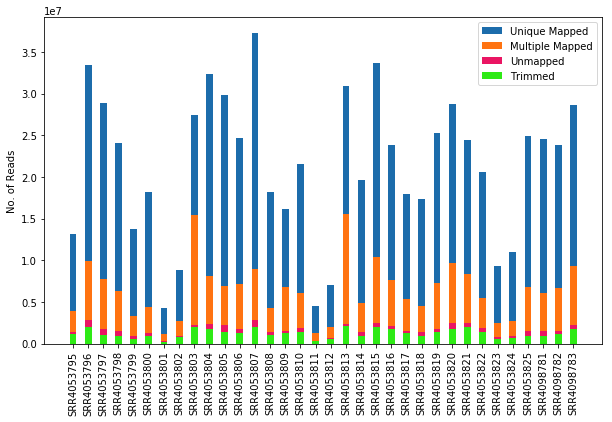

In [7]:
plt.figure(figsize=(10, 6)) 
N = 0
unique = []
multiple = []
unmapped = []
trimmed = []
for s in samples:
    if 'alignment' in samples_data[s]:
        N += 1
        unique.append(samples_data[s]['alignment']['unique'])
        multiple.append(samples_data[s]['alignment']['multiple'])
        unmapped.append(samples_data[s]['alignment']['unmapped'])
        trimmed.append(samples_data[s]['fastqc']['tot_seq'] - samples_data[s]['trimmed']['tot_seq'])
ind = np.arange(N) 
width = 0.45 

p4 = plt.bar(ind, trimmed, width, color='#2eea15')
p3 = plt.bar(ind, unmapped, width, bottom=np.array(trimmed), color='#ea1563')
p2 = plt.bar(ind, multiple, width, bottom=np.array(trimmed) + np.array(unmapped), color='#ff7311')
p1 = plt.bar(ind, unique, width, bottom=np.array(trimmed) + np.array(unmapped) + np.array(multiple), color='#1c6cab')

plt.ylabel('No. of Reads')
plt.xticks(ind, samples, rotation='vertical')
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Unique Mapped', 'Multiple Mapped', 'Unmapped', 'Trimmed'))

plt.show()
plt.close()

## 5. Alignment QC

In [8]:
str_msg = '### RSeQC BAM Stats\n\n'
str_msg += '| Sample | Total records | QC failed | Optical/PCR duplicate '
str_msg += '| mapq < mapq_cut (non-unique) | mapq >= mapq_cut (unique) '
str_msg += '| Reads map to \'+\' '
str_msg += '| Reads map to \'-\' '
str_msg += '| Non-splice reads '
str_msg += '| Splice reads '
str_msg += '|\n| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- '
str_msg += '|\n'
for s in samples:
    str_msg += '| ' + s
    str_msg += '| '
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', s + '_tr_sorted_rseqc.bam_stat.txt'))
    if os.path.exists(f):
        stats = {}
        with open(f) as fin:
            for line in fin:                
                fields = line.strip().split(':')
                if len(fields) == 2:
                    stats[fields[0]] = fields[1].strip()
        
        str_msg += "{:,}".format(int(stats['Total records'])) + ' |'
        str_msg += "{:,}".format(int(stats['QC failed'])) + ' |'
        str_msg += "{:,}".format(int(stats['Optical/PCR duplicate'])) + ' |'
        str_msg += "{:,}".format(int(stats['mapq < mapq_cut (non-unique)'])) + ' |'
        str_msg += "{:,}".format(int(stats['mapq >= mapq_cut (unique)'])) + ' |'
        str_msg += "{:,}".format(int(stats['Reads map to \'+\''])) + ' |'
        str_msg += "{:,}".format(int(stats['Reads map to \'-\''])) + ' |'
        str_msg += "{:,}".format(int(stats['Non-splice reads'])) + ' |'
        str_msg += "{:,}".format(int(stats['Splice reads'])) + ' |'
        
    else:
        str_msg += ' | --- | --- | --- | --- | --- | --- | --- | --- | --- '   
    str_msg += '\n'         
display(Markdown(str_msg))
del str_msg

### RSeQC BAM Stats

| Sample | Total records | QC failed | Optical/PCR duplicate | mapq < mapq_cut (non-unique) | mapq >= mapq_cut (unique) | Reads map to '+' | Reads map to '-' | Non-splice reads | Splice reads |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| SRR4053795| 22,991,408 |0 |0 |2,457,607 |9,305,716 |4,617,446 |4,688,270 |9,053,641 |252,075 |
| SRR4053796| 63,815,158 |0 |0 |7,150,345 |23,428,648 |11,698,780 |11,729,868 |22,479,769 |948,879 |
| SRR4053797| 53,792,361 |0 |0 |6,077,790 |21,112,138 |10,600,258 |10,511,880 |19,981,185 |1,130,953 |
| SRR4053798| 43,712,329 |0 |0 |4,827,940 |17,762,314 |8,855,480 |8,906,834 |16,861,418 |900,896 |
| SRR4053799| 23,778,131 |0 |0 |2,462,064 |10,383,923 |5,175,945 |5,207,978 |9,901,888 |482,035 |
| SRR4053800| 30,550,586 |0 |0 |3,136,023 |13,747,117 |6,850,268 |6,896,849 |13,163,477 |583,640 |
| SRR4053801| 7,478,284 |0 |0 |837,271 |3,153,377 |1,577,193 |1,576,184 |2,985,402 |167,975 |
| SRR4053802| 16,995,727 |0 |0 |1,796,274 |6,108,794 |3,037,305 |3,071,489 |5,952,001 |156,793 |
| SRR4053803| 90,895,977 |0 |0 |13,185,495 |12,003,772 |5,832,841 |6,170,931 |10,686,875 |1,316,897 |
| SRR4053804| 55,870,066 |0 |0 |5,775,846 |24,225,301 |12,104,472 |12,120,829 |23,015,930 |1,209,371 |
| SRR4053805| 53,502,564 |0 |0 |4,655,166 |22,901,692 |11,450,417 |11,451,275 |22,504,661 |397,031 |
| SRR4053806| 47,274,218 |0 |0 |5,457,761 |17,459,890 |8,725,346 |8,734,544 |16,400,442 |1,059,448 |
| SRR4053807| 62,006,939 |0 |0 |6,054,076 |28,352,820 |14,152,999 |14,199,821 |27,480,337 |872,483 |
| SRR4053808| 29,260,291 |0 |0 |2,842,045 |13,978,427 |6,976,961 |7,001,466 |13,217,191 |761,236 |
| SRR4053809| 39,566,730 |0 |0 |5,274,636 |9,365,187 |4,631,521 |4,733,666 |8,658,170 |707,017 |
| SRR4053810| 38,966,514 |0 |0 |4,237,042 |15,482,732 |7,724,212 |7,758,520 |14,624,948 |857,784 |
| SRR4053811| 8,194,295 |0 |0 |973,235 |3,243,686 |1,622,456 |1,621,230 |3,014,781 |228,905 |
| SRR4053812| 12,692,132 |0 |0 |1,418,937 |4,950,154 |2,461,017 |2,489,137 |4,683,598 |266,556 |
| SRR4053813| 90,789,333 |0 |0 |13,220,162 |15,421,803 |7,595,708 |7,826,095 |13,489,122 |1,932,681 |
| SRR4053814| 36,287,821 |0 |0 |3,571,161 |14,769,601 |7,377,817 |7,391,784 |14,304,588 |465,013 |
| SRR4053815| 64,975,360 |0 |0 |7,927,791 |23,357,577 |11,665,318 |11,692,259 |21,654,119 |1,703,458 |
| SRR4053816| 46,164,741 |0 |0 |5,463,758 |16,234,330 |8,093,168 |8,141,162 |15,322,595 |911,735 |
| SRR4053817| 32,928,401 |0 |0 |3,778,429 |12,672,358 |6,328,424 |6,343,934 |11,883,242 |789,116 |
| SRR4053818| 31,389,730 |0 |0 |3,069,559 |12,887,311 |6,501,264 |6,386,047 |12,478,146 |409,165 |
| SRR4053819| 45,829,798 |0 |0 |5,494,410 |17,953,686 |8,980,569 |8,973,117 |16,705,559 |1,248,127 |
| SRR4053820| 60,302,967 |0 |0 |7,285,902 |19,000,525 |9,421,611 |9,578,914 |17,954,136 |1,046,389 |
| SRR4053821| 48,550,843 |0 |0 |5,876,361 |15,977,515 |7,937,721 |8,039,794 |15,350,552 |626,963 |
| SRR4053822| 33,966,488 |0 |0 |3,644,191 |15,129,017 |7,550,435 |7,578,582 |14,415,247 |713,770 |
| SRR4053823| 16,021,760 |0 |0 |1,699,850 |6,923,827 |3,454,701 |3,469,126 |6,586,029 |337,798 |
| SRR4053824| 18,045,914 |0 |0 |1,862,895 |8,218,441 |4,085,621 |4,132,820 |7,879,484 |338,957 |
| SRR4053825| 47,840,789 |0 |0 |5,332,143 |18,086,250 |9,010,512 |9,075,738 |17,294,508 |791,742 |
| SRR4098781| 42,954,727 |0 |0 |4,502,358 |18,458,292 |9,239,051 |9,219,241 |17,656,835 |801,457 |
| SRR4098782| 42,955,598 |0 |0 |5,127,183 |17,169,879 |8,562,845 |8,607,034 |16,121,531 |1,048,348 |
| SRR4098783| 59,673,728 |0 |0 |7,073,588 |19,258,728 |9,593,117 |9,665,611 |18,151,902 |1,106,826 |


### RSeQC PDF plots

Click on figure to retrieve original PDF file

| Sample | Boxplot | HeatMap | Splice Events | Junction Saturation |
| --- | --- | --- | --- | --- |
| SRR4053795|  <a href="../results/PRJNA339968/quantification/SRR4053795_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">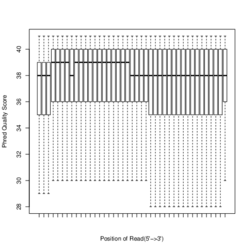</a> | <a href="../results/PRJNA339968/quantification/SRR4053795_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">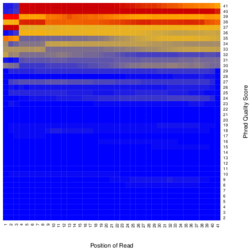</a> | <a href="../results/PRJNA339968/quantification/SRR4053795_tr_sorted_rseqc.splice_events.pdf" target="_blank">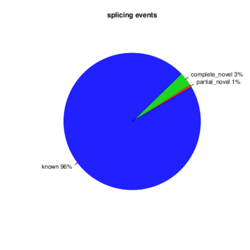</a> | <a href="../results/PRJNA339968/quantification/SRR4053795_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">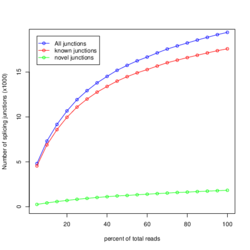</a> |
| SRR4053796|  <a href="../results/PRJNA339968/quantification/SRR4053796_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">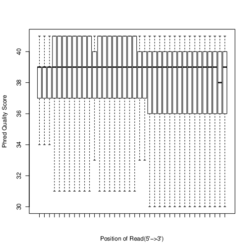</a> | <a href="../results/PRJNA339968/quantification/SRR4053796_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">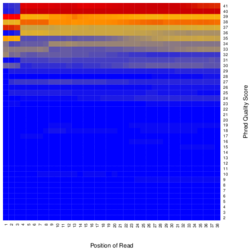</a> | <a href="../results/PRJNA339968/quantification/SRR4053796_tr_sorted_rseqc.splice_events.pdf" target="_blank">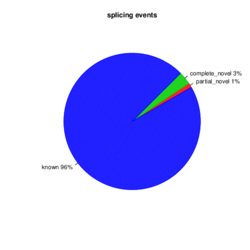</a> | <a href="../results/PRJNA339968/quantification/SRR4053796_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">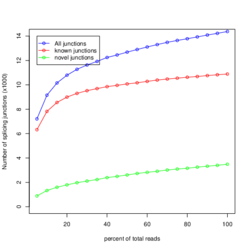</a> |
| SRR4053797|  <a href="../results/PRJNA339968/quantification/SRR4053797_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">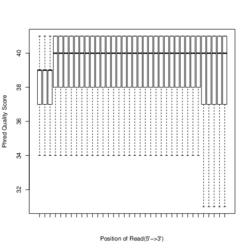</a> | <a href="../results/PRJNA339968/quantification/SRR4053797_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">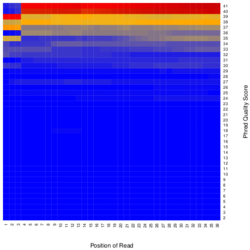</a> | <a href="../results/PRJNA339968/quantification/SRR4053797_tr_sorted_rseqc.splice_events.pdf" target="_blank">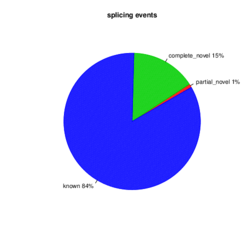</a> | <a href="../results/PRJNA339968/quantification/SRR4053797_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">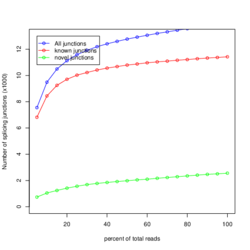</a> |
| SRR4053798|  <a href="../results/PRJNA339968/quantification/SRR4053798_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">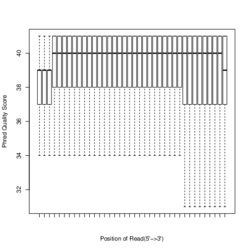</a> | <a href="../results/PRJNA339968/quantification/SRR4053798_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">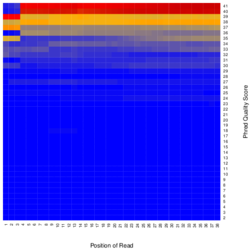</a> | <a href="../results/PRJNA339968/quantification/SRR4053798_tr_sorted_rseqc.splice_events.pdf" target="_blank">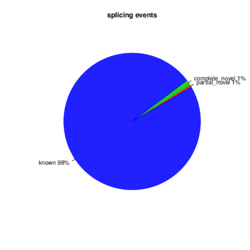</a> | <a href="../results/PRJNA339968/quantification/SRR4053798_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">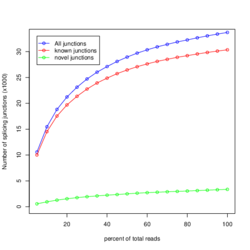</a> |
| SRR4053799|  <a href="../results/PRJNA339968/quantification/SRR4053799_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">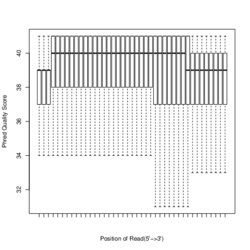</a> | <a href="../results/PRJNA339968/quantification/SRR4053799_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">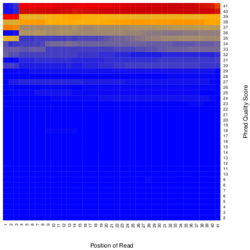</a> | <a href="../results/PRJNA339968/quantification/SRR4053799_tr_sorted_rseqc.splice_events.pdf" target="_blank">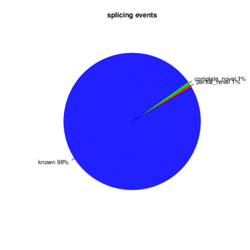</a> | <a href="../results/PRJNA339968/quantification/SRR4053799_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">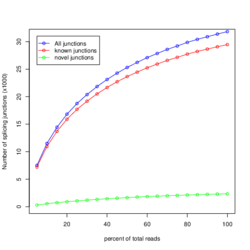</a> |
| SRR4053800|  <a href="../results/PRJNA339968/quantification/SRR4053800_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">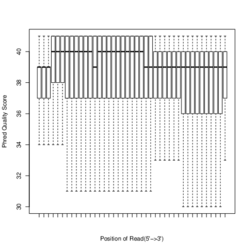</a> | <a href="../results/PRJNA339968/quantification/SRR4053800_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">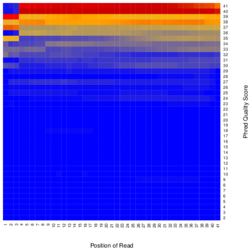</a> | <a href="../results/PRJNA339968/quantification/SRR4053800_tr_sorted_rseqc.splice_events.pdf" target="_blank">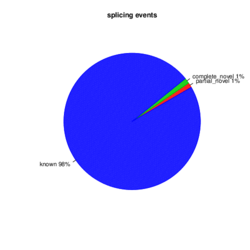</a> | <a href="../results/PRJNA339968/quantification/SRR4053800_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">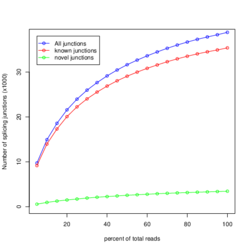</a> |
| SRR4053801|  <a href="../results/PRJNA339968/quantification/SRR4053801_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">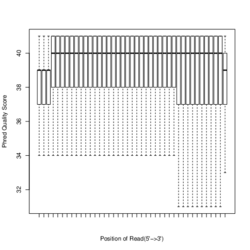</a> | <a href="../results/PRJNA339968/quantification/SRR4053801_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">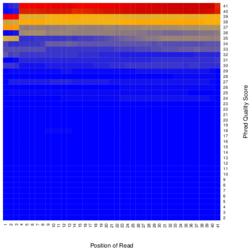</a> | <a href="../results/PRJNA339968/quantification/SRR4053801_tr_sorted_rseqc.splice_events.pdf" target="_blank">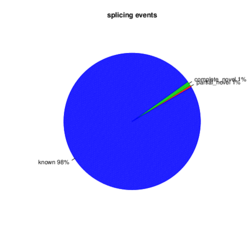</a> | <a href="../results/PRJNA339968/quantification/SRR4053801_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">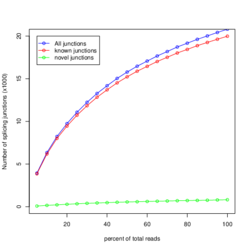</a> |
| SRR4053802|  <a href="../results/PRJNA339968/quantification/SRR4053802_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">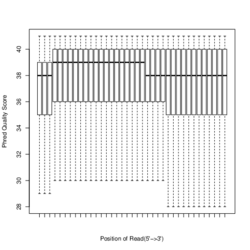</a> | <a href="../results/PRJNA339968/quantification/SRR4053802_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">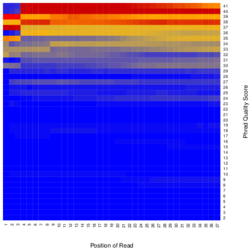</a> | <a href="../results/PRJNA339968/quantification/SRR4053802_tr_sorted_rseqc.splice_events.pdf" target="_blank">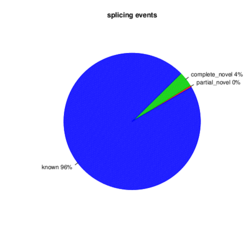</a> | <a href="../results/PRJNA339968/quantification/SRR4053802_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">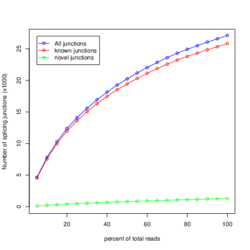</a> |
| SRR4053803|  <a href="../results/PRJNA339968/quantification/SRR4053803_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">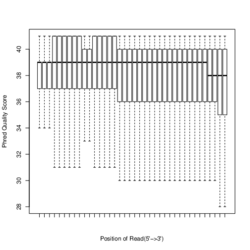</a> | <a href="../results/PRJNA339968/quantification/SRR4053803_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">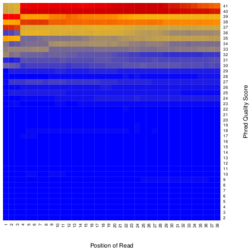</a> | <a href="../results/PRJNA339968/quantification/SRR4053803_tr_sorted_rseqc.splice_events.pdf" target="_blank">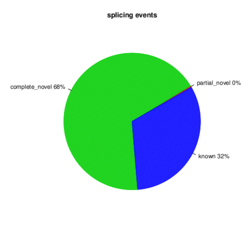</a> | <a href="../results/PRJNA339968/quantification/SRR4053803_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">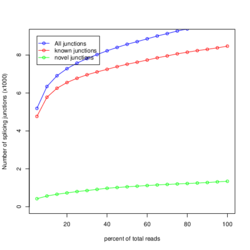</a> |
| SRR4053804|  <a href="../results/PRJNA339968/quantification/SRR4053804_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">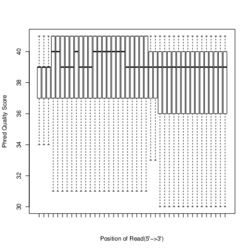</a> | <a href="../results/PRJNA339968/quantification/SRR4053804_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">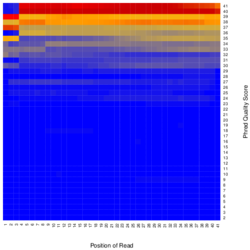</a> | <a href="../results/PRJNA339968/quantification/SRR4053804_tr_sorted_rseqc.splice_events.pdf" target="_blank">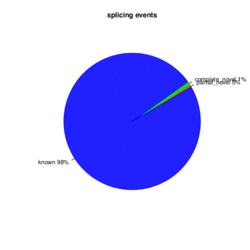</a> | <a href="../results/PRJNA339968/quantification/SRR4053804_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">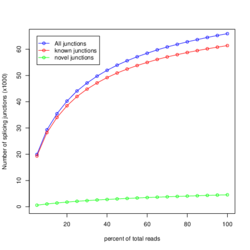</a> |
| SRR4053805|  <a href="../results/PRJNA339968/quantification/SRR4053805_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">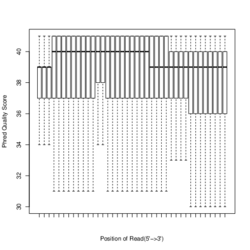</a> | <a href="../results/PRJNA339968/quantification/SRR4053805_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">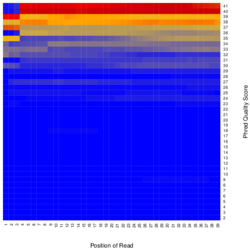</a> | <a href="../results/PRJNA339968/quantification/SRR4053805_tr_sorted_rseqc.splice_events.pdf" target="_blank">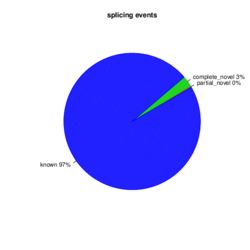</a> | <a href="../results/PRJNA339968/quantification/SRR4053805_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">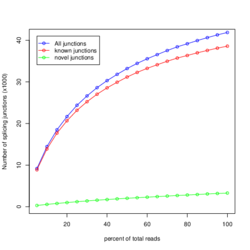</a> |
| SRR4053806|  <a href="../results/PRJNA339968/quantification/SRR4053806_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">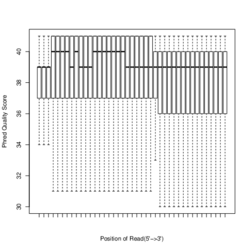</a> | <a href="../results/PRJNA339968/quantification/SRR4053806_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">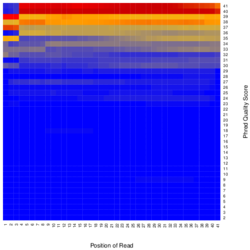</a> | <a href="../results/PRJNA339968/quantification/SRR4053806_tr_sorted_rseqc.splice_events.pdf" target="_blank">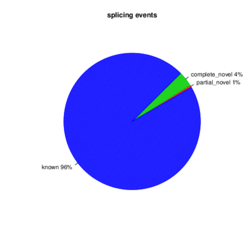</a> | <a href="../results/PRJNA339968/quantification/SRR4053806_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">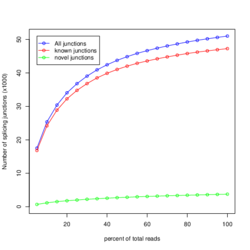</a> |
| SRR4053807|  <a href="../results/PRJNA339968/quantification/SRR4053807_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">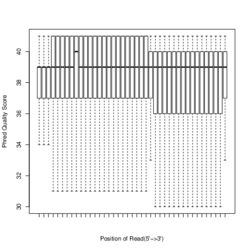</a> | <a href="../results/PRJNA339968/quantification/SRR4053807_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">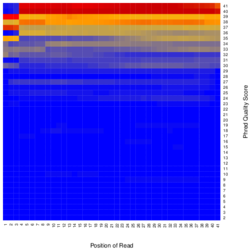</a> | <a href="../results/PRJNA339968/quantification/SRR4053807_tr_sorted_rseqc.splice_events.pdf" target="_blank">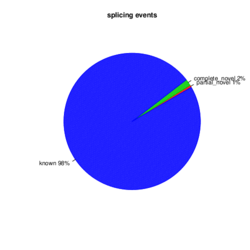</a> | <a href="../results/PRJNA339968/quantification/SRR4053807_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">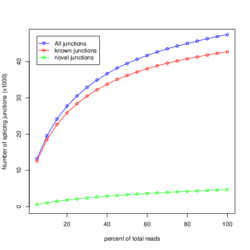</a> |
| SRR4053808|  <a href="../results/PRJNA339968/quantification/SRR4053808_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">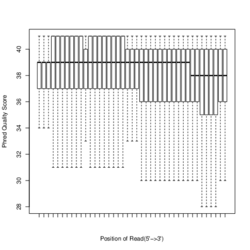</a> | <a href="../results/PRJNA339968/quantification/SRR4053808_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">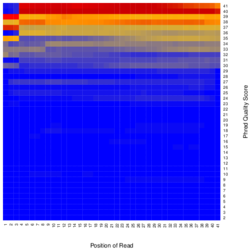</a> | <a href="../results/PRJNA339968/quantification/SRR4053808_tr_sorted_rseqc.splice_events.pdf" target="_blank">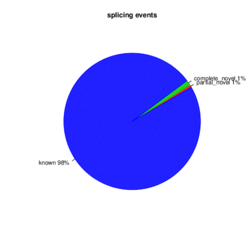</a> | <a href="../results/PRJNA339968/quantification/SRR4053808_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">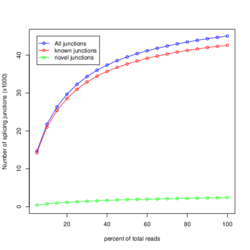</a> |
| SRR4053809|  <a href="../results/PRJNA339968/quantification/SRR4053809_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">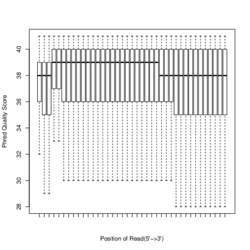</a> | <a href="../results/PRJNA339968/quantification/SRR4053809_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">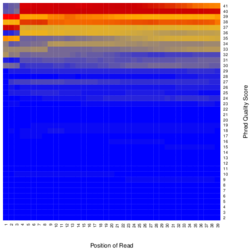</a> | <a href="../results/PRJNA339968/quantification/SRR4053809_tr_sorted_rseqc.splice_events.pdf" target="_blank">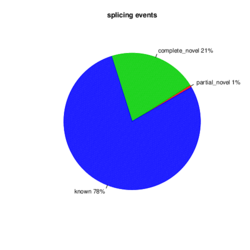</a> | <a href="../results/PRJNA339968/quantification/SRR4053809_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">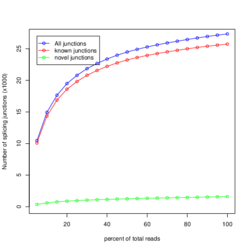</a> |
| SRR4053810|  <a href="../results/PRJNA339968/quantification/SRR4053810_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">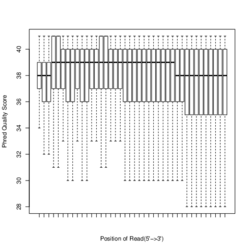</a> | <a href="../results/PRJNA339968/quantification/SRR4053810_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">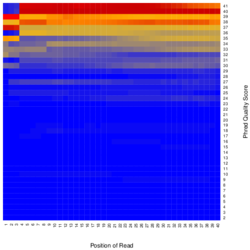</a> | <a href="../results/PRJNA339968/quantification/SRR4053810_tr_sorted_rseqc.splice_events.pdf" target="_blank">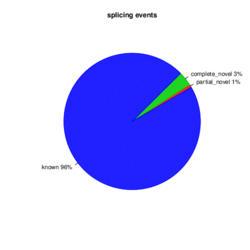</a> | <a href="../results/PRJNA339968/quantification/SRR4053810_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">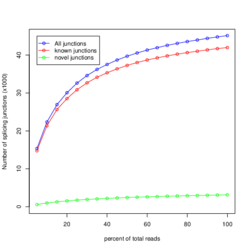</a> |
| SRR4053811|  <a href="../results/PRJNA339968/quantification/SRR4053811_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">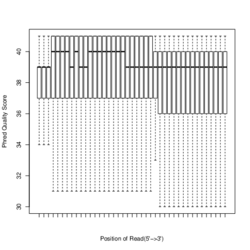</a> | <a href="../results/PRJNA339968/quantification/SRR4053811_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">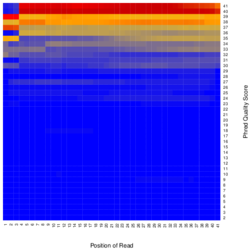</a> | <a href="../results/PRJNA339968/quantification/SRR4053811_tr_sorted_rseqc.splice_events.pdf" target="_blank">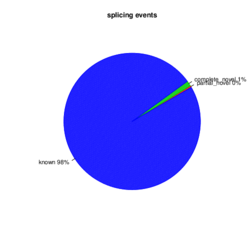</a> | <a href="../results/PRJNA339968/quantification/SRR4053811_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">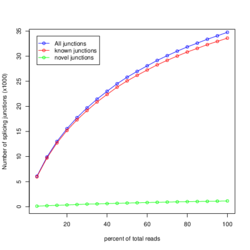</a> |
| SRR4053812|  <a href="../results/PRJNA339968/quantification/SRR4053812_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">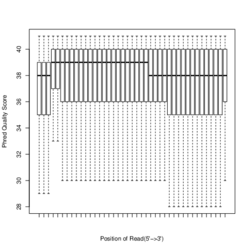</a> | <a href="../results/PRJNA339968/quantification/SRR4053812_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">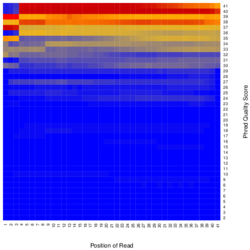</a> | <a href="../results/PRJNA339968/quantification/SRR4053812_tr_sorted_rseqc.splice_events.pdf" target="_blank">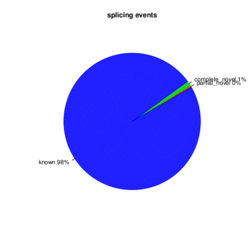</a> | <a href="../results/PRJNA339968/quantification/SRR4053812_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">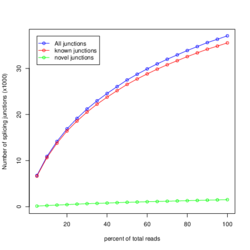</a> |
| SRR4053813|  <a href="../results/PRJNA339968/quantification/SRR4053813_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">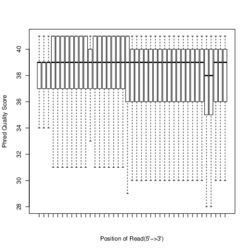</a> | <a href="../results/PRJNA339968/quantification/SRR4053813_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">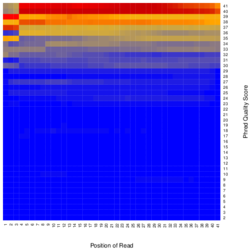</a> | <a href="../results/PRJNA339968/quantification/SRR4053813_tr_sorted_rseqc.splice_events.pdf" target="_blank">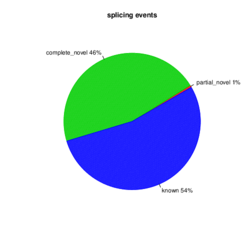</a> | <a href="../results/PRJNA339968/quantification/SRR4053813_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">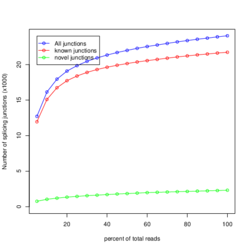</a> |
| SRR4053814|  <a href="../results/PRJNA339968/quantification/SRR4053814_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">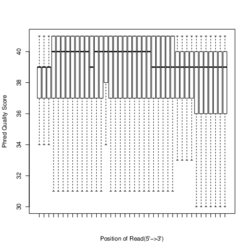</a> | <a href="../results/PRJNA339968/quantification/SRR4053814_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">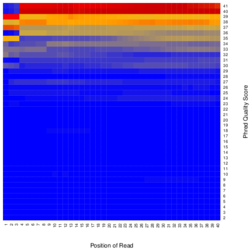</a> | <a href="../results/PRJNA339968/quantification/SRR4053814_tr_sorted_rseqc.splice_events.pdf" target="_blank">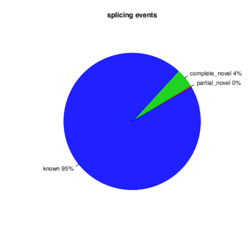</a> | <a href="../results/PRJNA339968/quantification/SRR4053814_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">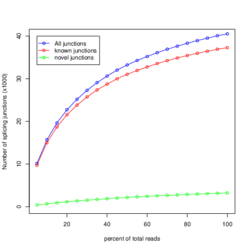</a> |
| SRR4053815|  <a href="../results/PRJNA339968/quantification/SRR4053815_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">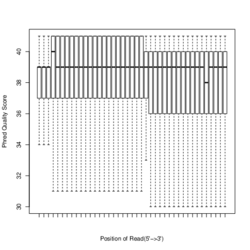</a> | <a href="../results/PRJNA339968/quantification/SRR4053815_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">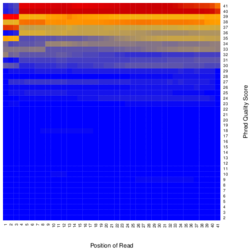</a> | <a href="../results/PRJNA339968/quantification/SRR4053815_tr_sorted_rseqc.splice_events.pdf" target="_blank">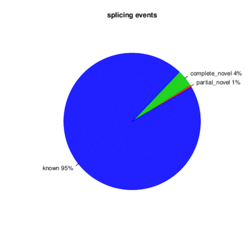</a> | <a href="../results/PRJNA339968/quantification/SRR4053815_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">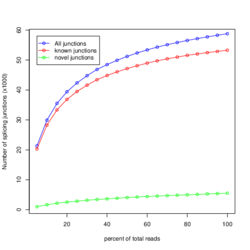</a> |
| SRR4053816|  <a href="../results/PRJNA339968/quantification/SRR4053816_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">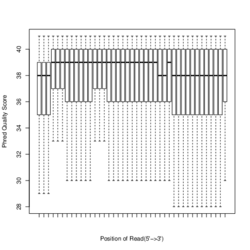</a> | <a href="../results/PRJNA339968/quantification/SRR4053816_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">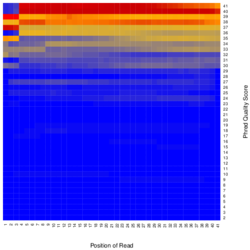</a> | <a href="../results/PRJNA339968/quantification/SRR4053816_tr_sorted_rseqc.splice_events.pdf" target="_blank">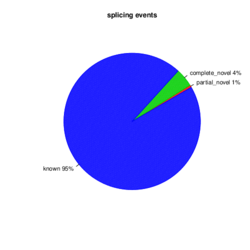</a> | <a href="../results/PRJNA339968/quantification/SRR4053816_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">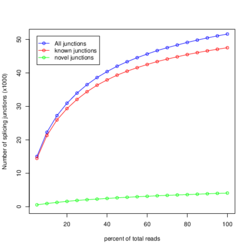</a> |
| SRR4053817|  <a href="../results/PRJNA339968/quantification/SRR4053817_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">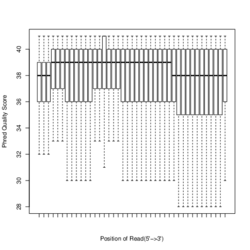</a> | <a href="../results/PRJNA339968/quantification/SRR4053817_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">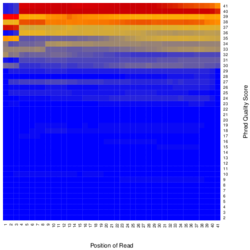</a> | <a href="../results/PRJNA339968/quantification/SRR4053817_tr_sorted_rseqc.splice_events.pdf" target="_blank">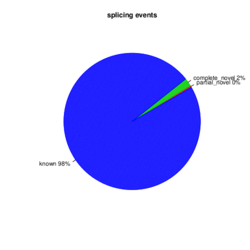</a> | <a href="../results/PRJNA339968/quantification/SRR4053817_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">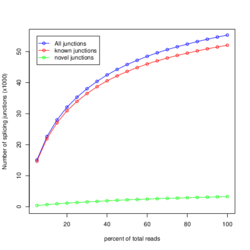</a> |
| SRR4053818|  <a href="../results/PRJNA339968/quantification/SRR4053818_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">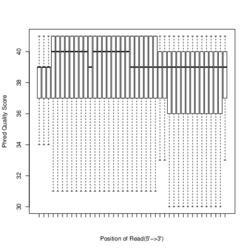</a> | <a href="../results/PRJNA339968/quantification/SRR4053818_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">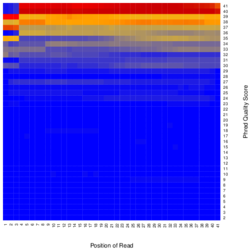</a> | <a href="../results/PRJNA339968/quantification/SRR4053818_tr_sorted_rseqc.splice_events.pdf" target="_blank">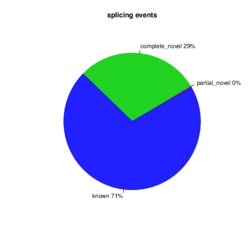</a> | <a href="../results/PRJNA339968/quantification/SRR4053818_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">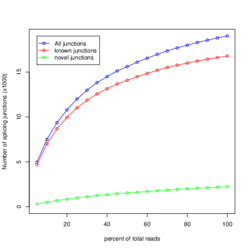</a> |
| SRR4053819|  <a href="../results/PRJNA339968/quantification/SRR4053819_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">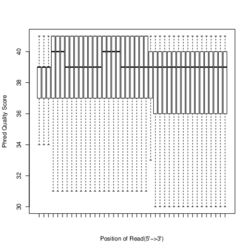</a> | <a href="../results/PRJNA339968/quantification/SRR4053819_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">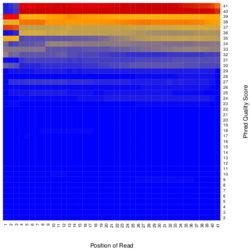</a> | <a href="../results/PRJNA339968/quantification/SRR4053819_tr_sorted_rseqc.splice_events.pdf" target="_blank">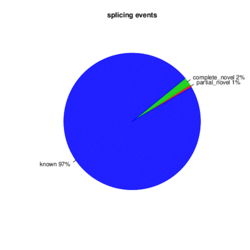</a> | <a href="../results/PRJNA339968/quantification/SRR4053819_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">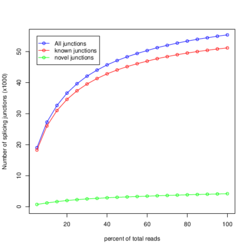</a> |
| SRR4053820|  <a href="../results/PRJNA339968/quantification/SRR4053820_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">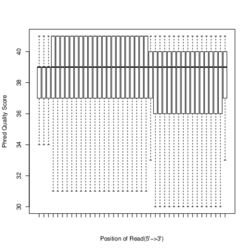</a> | <a href="../results/PRJNA339968/quantification/SRR4053820_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">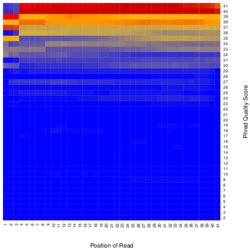</a> | <a href="../results/PRJNA339968/quantification/SRR4053820_tr_sorted_rseqc.splice_events.pdf" target="_blank">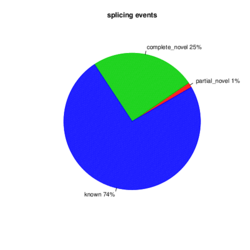</a> | <a href="../results/PRJNA339968/quantification/SRR4053820_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">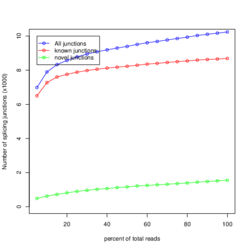</a> |
| SRR4053821|  <a href="../results/PRJNA339968/quantification/SRR4053821_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">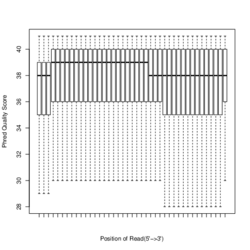</a> | <a href="../results/PRJNA339968/quantification/SRR4053821_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">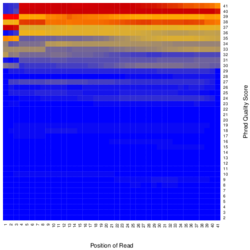</a> | <a href="../results/PRJNA339968/quantification/SRR4053821_tr_sorted_rseqc.splice_events.pdf" target="_blank">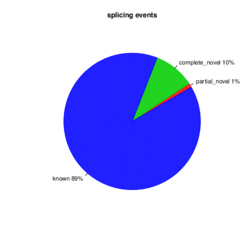</a> | <a href="../results/PRJNA339968/quantification/SRR4053821_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">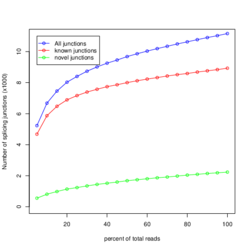</a> |
| SRR4053822|  <a href="../results/PRJNA339968/quantification/SRR4053822_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">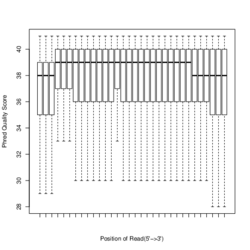</a> | <a href="../results/PRJNA339968/quantification/SRR4053822_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">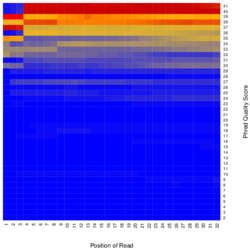</a> | <a href="../results/PRJNA339968/quantification/SRR4053822_tr_sorted_rseqc.splice_events.pdf" target="_blank">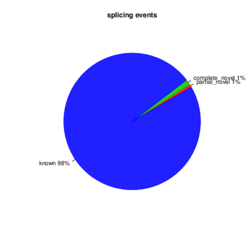</a> | <a href="../results/PRJNA339968/quantification/SRR4053822_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">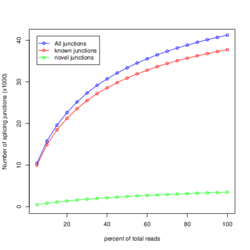</a> |
| SRR4053823|  <a href="../results/PRJNA339968/quantification/SRR4053823_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">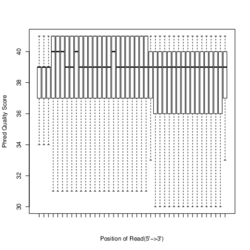</a> | <a href="../results/PRJNA339968/quantification/SRR4053823_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">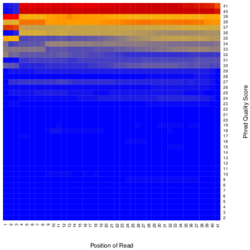</a> | <a href="../results/PRJNA339968/quantification/SRR4053823_tr_sorted_rseqc.splice_events.pdf" target="_blank">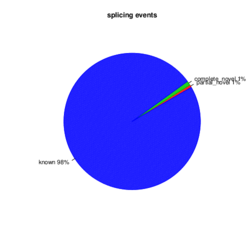</a> | <a href="../results/PRJNA339968/quantification/SRR4053823_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">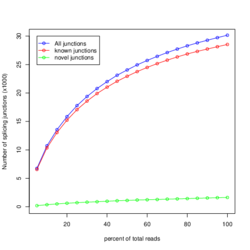</a> |
| SRR4053824|  <a href="../results/PRJNA339968/quantification/SRR4053824_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">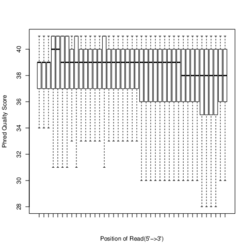</a> | <a href="../results/PRJNA339968/quantification/SRR4053824_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">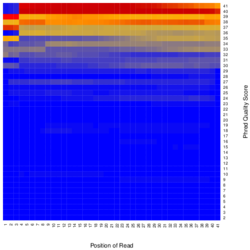</a> | <a href="../results/PRJNA339968/quantification/SRR4053824_tr_sorted_rseqc.splice_events.pdf" target="_blank">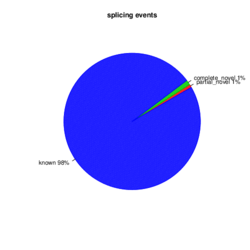</a> | <a href="../results/PRJNA339968/quantification/SRR4053824_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">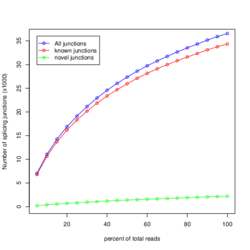</a> |
| SRR4053825|  <a href="../results/PRJNA339968/quantification/SRR4053825_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">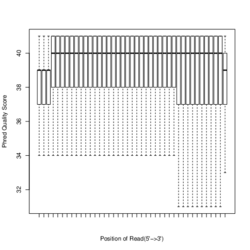</a> | <a href="../results/PRJNA339968/quantification/SRR4053825_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">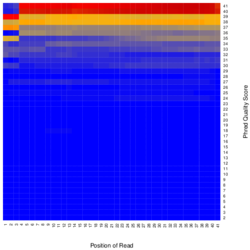</a> | <a href="../results/PRJNA339968/quantification/SRR4053825_tr_sorted_rseqc.splice_events.pdf" target="_blank">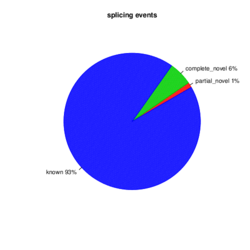</a> | <a href="../results/PRJNA339968/quantification/SRR4053825_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">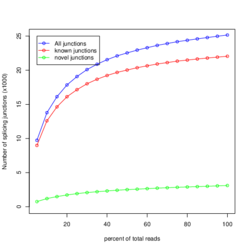</a> |
| SRR4098781|  <a href="../results/PRJNA339968/quantification/SRR4098781_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">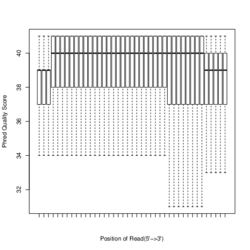</a> | <a href="../results/PRJNA339968/quantification/SRR4098781_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">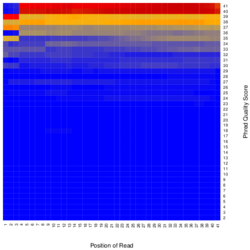</a> | <a href="../results/PRJNA339968/quantification/SRR4098781_tr_sorted_rseqc.splice_events.pdf" target="_blank">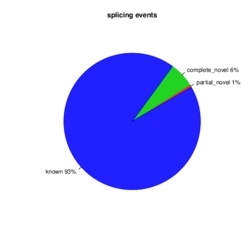</a> | <a href="../results/PRJNA339968/quantification/SRR4098781_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">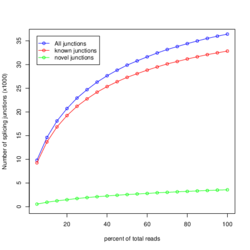</a> |
| SRR4098782|  <a href="../results/PRJNA339968/quantification/SRR4098782_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">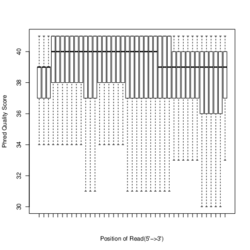</a> | <a href="../results/PRJNA339968/quantification/SRR4098782_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">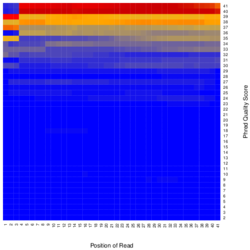</a> | <a href="../results/PRJNA339968/quantification/SRR4098782_tr_sorted_rseqc.splice_events.pdf" target="_blank">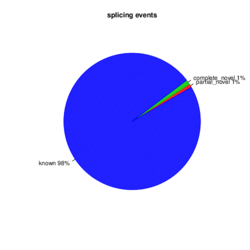</a> | <a href="../results/PRJNA339968/quantification/SRR4098782_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">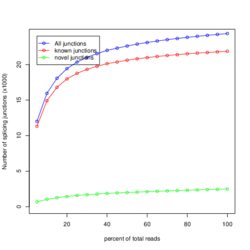</a> |
| SRR4098783|  <a href="../results/PRJNA339968/quantification/SRR4098783_tr_sorted_rseqc.qual.boxplot.pdf" target="_blank">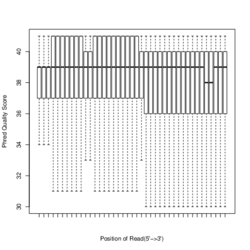</a> | <a href="../results/PRJNA339968/quantification/SRR4098783_tr_sorted_rseqc.qual.heatmap.pdf" target="_blank">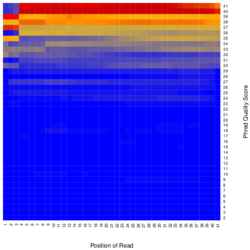</a> | <a href="../results/PRJNA339968/quantification/SRR4098783_tr_sorted_rseqc.splice_events.pdf" target="_blank">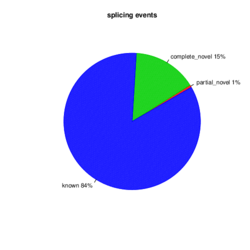</a> | <a href="../results/PRJNA339968/quantification/SRR4098783_tr_sorted_rseqc.junctionSaturation_plot.pdf" target="_blank">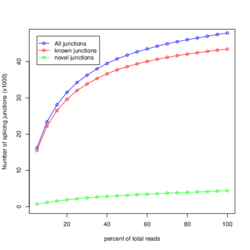</a> |


In [9]:
img_size = 250
str_msg = '### RSeQC PDF plots\n\n'
str_msg += 'Click on figure to retrieve original PDF file\n\n'
str_msg += '| Sample | Boxplot | HeatMap | Splice Events | Junction Saturation '
str_msg += '|\n| --- | --- | --- | --- | --- '
str_msg += '|\n'
for s in samples:
    str_msg += '| ' + s
    str_msg += '| '
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', s + '_tr_sorted_rseqc.qual.boxplot.pdf'))
    if os.path.exists(f):
        with WImage(filename=f) as img:
            img.resize(img_size, img_size)
            img = img.convert('png')
            str_msg += ' <a href="' 
            str_msg += f.replace(' ', '%20') 
            str_msg += '" target="_blank">'
            str_msg += '<img src="data:image/png;base64,' + base64.b64encode(img.make_blob()).decode('utf-8') + '">'
            str_msg += '</a> |'            
    else:
        str_msg += ' --- |' 
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', s + '_tr_sorted_rseqc.qual.heatmap.pdf'))
    if os.path.exists(f):
        with WImage(filename=f) as img:
            img.resize(img_size, img_size)
            img = img.convert('png')
            str_msg += ' <a href="' 
            str_msg += f.replace(' ', '%20') 
            str_msg += '" target="_blank">'
            str_msg += '<img src="data:image/png;base64,' + base64.b64encode(img.make_blob()).decode('utf-8') + '">'
            str_msg += '</a> |' 
    else:
        str_msg += ' --- |' 
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', s + '_tr_sorted_rseqc.splice_events.pdf'))
    if os.path.exists(f):
        with WImage(filename=f) as img:
            img.resize(img_size, img_size)
            img = img.convert('png')
            str_msg += ' <a href="' 
            str_msg += f.replace(' ', '%20') 
            str_msg += '" target="_blank">'
            str_msg += '<img src="data:image/png;base64,' + base64.b64encode(img.make_blob()).decode('utf-8') + '">'
            str_msg += '</a> |' 
    else:
        str_msg += ' --- |'
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', s + '_tr_sorted_rseqc.junctionSaturation_plot.pdf'))
    if os.path.exists(f):
        with WImage(filename=f) as img:
            img.resize(img_size, img_size)
            img = img.convert('png')
            str_msg += ' <a href="' 
            str_msg += f.replace(' ', '%20') 
            str_msg += '" target="_blank">'
            str_msg += '<img src="data:image/png;base64,' + base64.b64encode(img.make_blob()).decode('utf-8') + '">'
            str_msg += '</a> |'
    else:
        str_msg += ' --- |'
    str_msg += '\n'
display(Markdown(str_msg))
del str_msg


## 6. Quantification

<a href="04%20-%20Quantification.html" target="_blank">04 - Quantification</a>

<a href="../results/PRJNA339968/" target="_blank">Results folder</a>

[ExonTPM.tsv](../results/PRJNA339968/quantification/ExonTPM.tsv)
[ExonReads.tsv](../results/PRJNA339968/quantification/ExonReads.tsv)


### Exon TPM and reads distribution per sample

Text(0.5,1,'Exon reads')

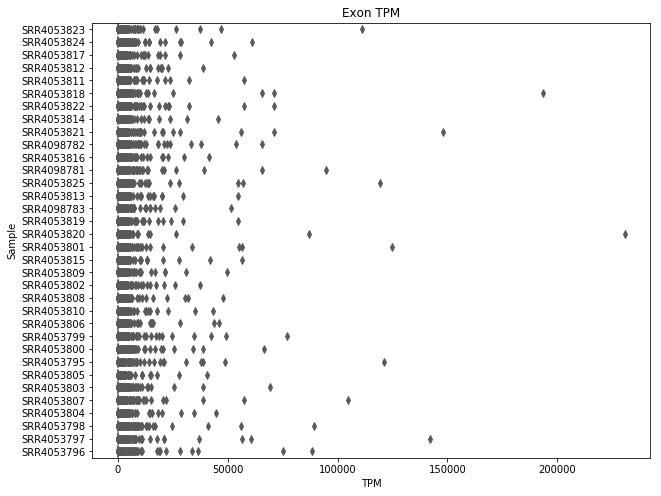

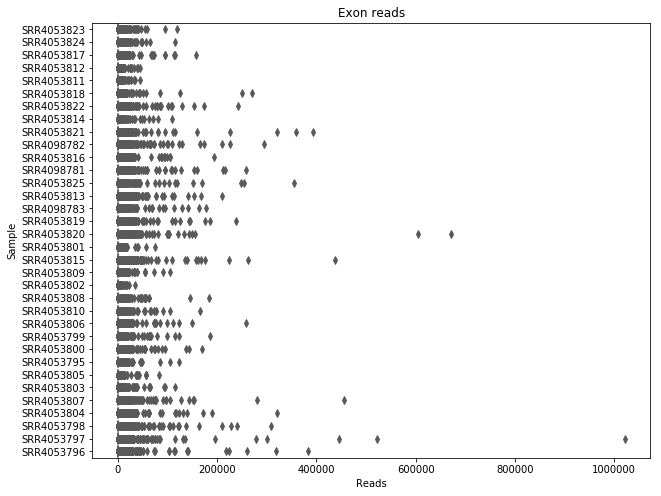

In [10]:
os.chdir(os.environ['NOTEBOOKS'])
name = '04 - Quantification'
str_msg = '<a href="' + name.replace(' ', '%20') + '.html" target="_blank">' + name + '</a>\n\n'
str_msg += '<a href="../results/' + os.environ['DATASET'] + '/" target="_blank">Results folder</a>\n\n'
columns = ['ExonTPM', 'ExonReads']
data = {}
samples = [ f.replace('_tr_sorted.bam','') for ds,dr,fs in os.walk(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification')) for f in fs if f.endswith('_sorted.bam')]
for c in columns:
    f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'quantification', c + '.tsv'))
    if os.path.exists(f):
        str_msg += '[' + c + '.tsv](' + f + ')\n'
        data[c] = pandas.read_csv(f, sep='\t')

display(Markdown(str_msg))
del str_msg

display(Markdown("### Exon TPM and reads distribution per sample"))
plt.figure(figsize=(10, 8)) 
toPlot = []
for s in samples:
    if s in data['ExonTPM']:
        for r in data['ExonTPM'][s]:
            toPlot.append([r, s])
d = pandas.DataFrame(toPlot, columns=['TPM', 'Sample'])
ax = sns.boxplot(y='Sample', x='TPM', data=d, orient="h", palette="Set2")
ax.set_title('Exon TPM')

plt.figure(figsize=(10, 8)) 
toPlot = []
for s in samples:
    if s in data['ExonReads']:
        for r in data['ExonReads'][s]:
            toPlot.append([r, s])
d = pandas.DataFrame(toPlot, columns=['Reads', 'Sample'])
ax = sns.boxplot(y='Sample', x='Reads', data=d, orient="h", palette="Set2")
ax.set_title('Exon reads')

## 7. Differential Gene Expression Analysis

## 8. Correlation with published results

### 8.1 Correlation results

#### 8.1.1 Recall

Reference     Union  Interception     EdgeR     Deseq    SAMseq  \
0         SAM-Frank  0.441002      0.081622  0.158371  0.147755  0.363035   
1       SAM-Haniffa  0.535156      0.106771  0.225260  0.227214  0.458333   
2     SAM-Ingersoll  0.451633      0.085985  0.170706  0.161644  0.376396   
3          SAM-Wong  0.420285      0.084752  0.156652  0.151441  0.352206   
4       limma-Frank  0.533368      0.102293  0.210770  0.198660  0.448596   
5     limma-Haniffa  0.590909      0.118182  0.233690  0.231016  0.497861   
6   limma-Ingersoll  0.533237      0.100915  0.202071  0.191956  0.445809   
7        limma-Wong  0.538778      0.100764  0.176263  0.170975  0.438014   
8         int-Frank  0.500908      0.095532  0.187069  0.173992  0.415547   
9       int-Haniffa  0.609929      0.124113  0.262411  0.264184  0.518617   
10    int-Ingersoll  0.505136      0.096845  0.185253  0.175348  0.418195   
11         int-Wong  0.558008      0.111910  0.207392  0.199179  0.465606   

         MWU  
0   0.054647  
1   0.076823  
2   0.058799  
3   0.061132  
4   0.068281  
5   0.091444  
6   0.069846  
7   0.074031  
8   0.063204  
9   0.090426  
10  0.066398  
11  0.080595

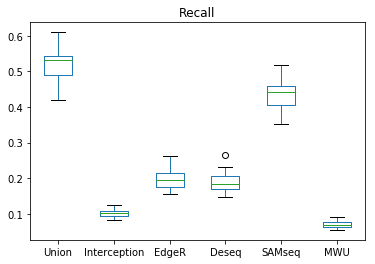

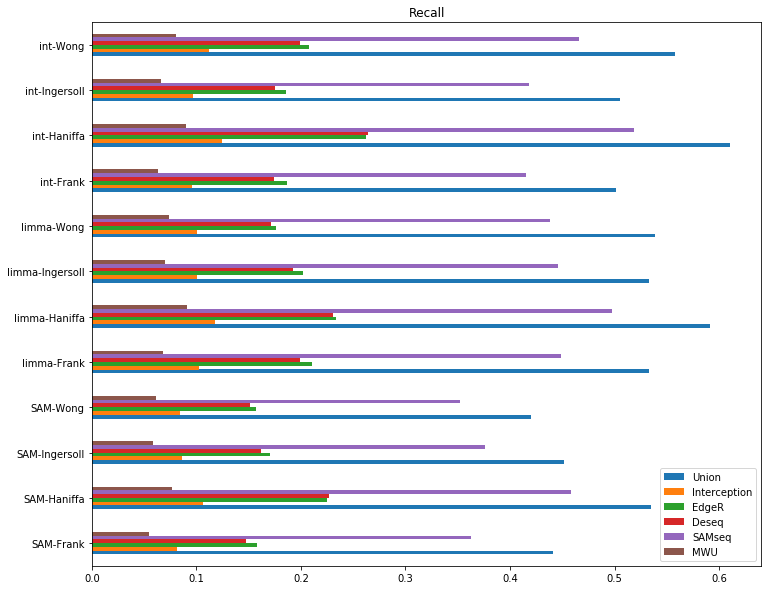

In [11]:
f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'differential_expression', 'recall.csv'))
df = pandas.read_csv(f, sep='\t')
display(df)
df.plot.box(title='Recall')
df.plot.barh(figsize=(12, 10), title='Recall').set_yticklabels(df['Reference'], rotation=0);

#### 8.1.2 Precision

Reference     Union  Interception     EdgeR     Deseq    SAMseq  \
0         SAM-Frank  0.408776      0.491614  0.555895  0.563745  0.436584   
1       SAM-Haniffa  0.132602      0.171908  0.211362  0.231740  0.147342   
2     SAM-Ingersoll  0.345701      0.427673  0.494808  0.509296  0.373797   
3          SAM-Wong  0.195193      0.255765  0.275504  0.289509  0.212223   
4       limma-Frank  0.333925      0.416143  0.499695  0.511952  0.364378   
5     limma-Haniffa  0.178255      0.231656  0.266952  0.286853  0.194851   
6   limma-Ingersoll  0.357154      0.439203  0.512523  0.529216  0.387401   
7        limma-Wong  0.295854      0.359539  0.366524  0.386454  0.312055   
8         int-Frank  0.222455      0.275681  0.314600  0.318061  0.239431   
9       int-Haniffa  0.110986      0.146751  0.180819  0.197875  0.122436   
10    int-Ingersoll  0.222133      0.276730  0.308491  0.317397  0.238594   
11         int-Wong  0.175351      0.228512  0.246793  0.257636  0.189828   

         MWU  
0   0.428377  
1   0.160982  
2   0.380628  
3   0.240109  
4   0.361528  
5   0.233288  
6   0.395634  
7   0.343793  
8   0.237381  
9   0.139154  
10  0.246930  
11  0.214188

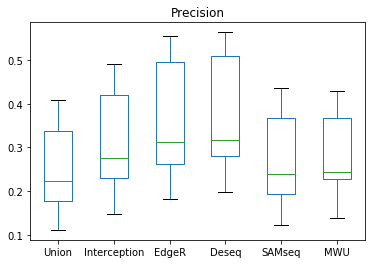

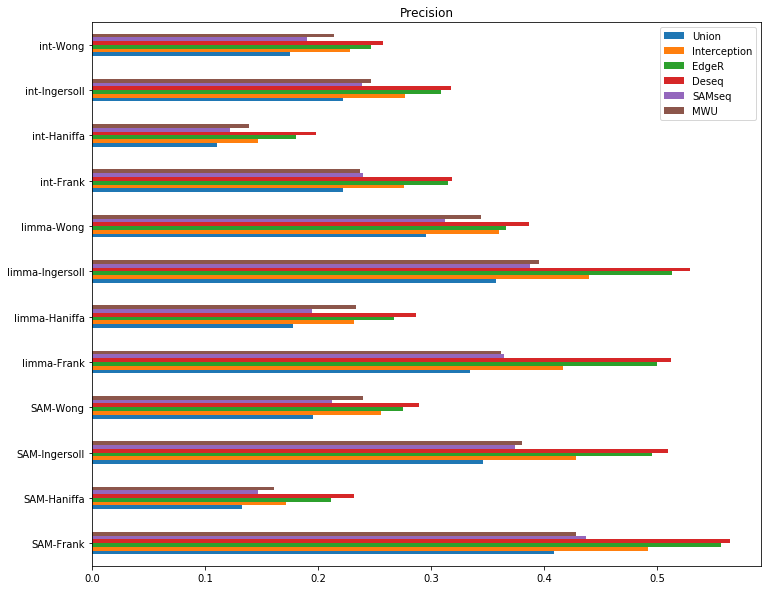

In [12]:
f = os.path.relpath(os.path.join(os.environ['RESULTS'], os.environ['DATASET'], 'differential_expression', 'precision.csv'))
df = pandas.read_csv(f, sep='\t')
display(df)
df.plot.box(title='Precision')
df.plot.barh(figsize=(12, 10), title='Precision').set_yticklabels(df['Reference'], rotation=0);

### 8.2 Recall and precision

We used figure 5a plotting our workflow recall and precision results as described in the paper. Our workflow shows recall and precision values similar to analyzed workflows that uses the same tools and quantification tool similar to TPMCalculator.

#### 8.2.1 Recall

<img src="../results/PRJNA339968/recall.png" alt="Recall plot" width="650px"/>

#### 8.2.2 Precision

<img src="../results/PRJNA339968/precision.png" alt="Precision plot" width="650px"/>